## step 4 - Building a Predictive Model for Hotel Pricing Dynamics Using Snapshot Data (V2)




- **Objective:**  
  Predict the `Discount Price` for check-in dates within 30 days of a given `Snapshot Date` while minimizing the number of price samples (queries) from the database.

- **Context:**  
  Given fields of `Snapshot Date`, `Hotel Name`, `Discount Code`, build a relevant data set to predict the `Discount Price` for check-in dates within 30 days of the `Snapshot Date`.

- **Performance Measure:**  
  The model's success is evaluated by the R-squared metric on a subset of 40 hotels with the most complete data.


### Solution Approaches: Gaussian Process Regression vs. Bayesian Linear and Polynomial Regression



#### Gaussian Process Regression



- **Pros:**
  - **Uncertainty Quantification:** Provides both predictions and confidence intervals, which is key for active sampling.
  - **Sample Efficiency:** Excels when data is limited, helping us select the most informative samples.
  - **Flexibility:** Capable of modeling complex, non-linear relationships inherent in price trends.
  
- **Cons:**
  - **Computational Cost:** Can become computationally expensive with larger datasets.
  - **Kernel Selection:** Requires careful tuning of the kernel functions to capture the underlying data patterns accurately.

- **Fit to the Problem:**  
  Ideal for our task since its uncertainty estimates allow us to strategically choose the next check-in dates to sample, ensuring we use as few queries as possible while maintaining high prediction performance.




#### Bayesian Linear and Polynomial Regression



- **Pros:**
  - **Simplicity:** Easy to implement and interpret.
  - **Speed:** Generally faster to train compared to GP, which can be advantageous with simpler or smooth trends.
  
- **Cons:**
  - **Limited Flexibility:** May not capture complex non-linear patterns as effectively.
  - **Uncertainty Estimates:** While Bayesian methods provide uncertainty measures, they are often less robust in capturing the variability in complex datasets compared to GP.

- **Fit to the Problem:**  
  Suitable if the price trends were very smooth and predictable. However, the nuances in hotel pricing (e.g., varying discount strategies, day-of-week effects) suggest a need for a more flexible approach.




#### Chosen Approach:



- **Gaussian Process Regression** is selected as the primary method. Its ability to provide uncertainty estimates and guide active sampling makes it the best fit for minimizing the number of price queries while still achieving a high R-squared on the test set.


### Data Loading and Extraction:

1. **Load the Data:**  
   We read the CSV file into a DataFrame and ensure that date columns are properly converted to datetime objects.

2. **Filter the Data:**  
   We filter the dataset to include only rows where `DayDiff` is 30 or less, meaning the check-in is within 30 days after the snapshot date.

3. **Group the Data:**  
   We group by `Snapshot Date`, `Hotel Name`, and `Discount Code`, and count the number of transactions (rows) in each group. This count is stored in the column `transaction_count`.

4. **Dataset: onePerHotel:**  
   - For each hotel, we sort by `transaction_count` in descending order and select the combination with the maximum count.  
   - Then, we sort these unique hotel rows by `transaction_count` and take the top 40.

5. **Dataset: mostData:**  
   - We simply sort all the grouped combinations by `transaction_count` in descending order and select the top 40 combinations.

6. **Extracting Parameters:**  
   For each dataset, we extract a list of dictionaries (or "params") containing `Snapshot Date`, `Hotel Name`, and `Discount Code`.


In [5]:
import pandas as pd

data_path = "./hotels_data_changed.csv"
data = pd.read_csv(data_path)

# We are only interested in transactions with a check-in date within 30 days after the snapshot.
data_filtered = data[data['DayDiff'] <= 30].copy()

data_filtered['Snapshot Date'] = pd.to_datetime(data_filtered['Snapshot Date']).dt.normalize()

# We group by the combination of 'Snapshot Date', 'Hotel Name', and 'Discount Code', and count the number of transactions.
grouped = data_filtered.groupby(
    ['Snapshot Date', 'Hotel Name', 'Discount Code']
).size().reset_index(name='transaction_count')

# For each hotel, choose the combination with the highest transaction_count.
# First, sort within each hotel so that the highest count is on top,
# then group by 'Hotel Name' and take the first (best) row.
onePerHotel = (
    grouped.sort_values(['Hotel Name', 'transaction_count'], ascending=[True, False])
    .groupby('Hotel Name')
    .first()
    .reset_index()
)

onePerHotel = onePerHotel.sort_values('transaction_count', ascending=False).head(40)

mostData = grouped.sort_values('transaction_count', ascending=False).head(40)

params_onePerHotel = onePerHotel[['Snapshot Date', 'Hotel Name', 'Discount Code']].to_dict('records')
params_mostData   = mostData[['Snapshot Date', 'Hotel Name', 'Discount Code']].to_dict('records')

print("onePerHotel (Top 40 hotels with best combination per hotel):")
display(onePerHotel.head())

print("mostData (Top 40 combinations overall):")
display(mostData.head())

onePerHotel (Top 40 hotels with best combination per hotel):


,Hotel Name,Snapshot Date,Discount Code,transaction_count
339,Park Hyatt New York,2015-07-22,3,44
325,Newark Liberty International Airport Marriott,2015-07-22,3,30
468,The New York EDITION,2015-07-27,2,30
168,Hampton Inn Madison Square Garden Area Hotel,2015-07-23,4,26
431,The Carlyle A Rosewood Hotel,2015-12-20,4,26


mostData (Top 40 combinations overall):


,Snapshot Date,Hotel Name,Discount Code,transaction_count
1684,2015-07-22,Park Hyatt New York,3,44
1683,2015-07-22,Park Hyatt New York,2,43
1682,2015-07-22,Park Hyatt New York,1,30
3312,2015-07-27,The New York EDITION,2,30
1967,2015-07-23,Newark Liberty International Airport Marriott,3,30


### Feature Engineering and Data Preparation 

In this section we would create a function that gets the `Snapshot Date`, `Hotel Name`, and `Discount Code` and returns all we need to start training the model.
This includes the following:
-  get relevant data from the dataset
-  apply feature engineering on that data
-  normalize and scale the data
-  Splitting into X and y & Creating the Wrapper Function

#### Get the data 

In [6]:
def load_relevant_data(params, data):
 
    snapshot_date = pd.to_datetime(params['Snapshot Date']).normalize()
    
    subset = data[
        (data['Snapshot Date'] == snapshot_date) &
        (data['Hotel Name'] == params['Hotel Name']) &
        (data['Discount Code'] == params['Discount Code']) &
        (data['DayDiff'] <= 30) 
    ]
    return subset

test_params = params_mostData[0]
relevant_subset = load_relevant_data(test_params, data_filtered)
print("Parameters:", test_params)
print("Relevant Data (first 5 rows):")
display(relevant_subset.head())

Parameters: {'Snapshot Date': Timestamp('2015-07-22 00:00:00'), 'Hotel Name': 'Park Hyatt New York', 'Discount Code': 3}
Relevant Data (first 5 rows):


,Snapshot ID,Snapshot Date,Checkin Date,Days,Original Price,Discount Price,Discount Code,Available Rooms,Hotel Name,Hotel Stars,DayDiff,WeekDay,DiscountDiff,DiscountPerc
4119,11,2015-07-22,2015-07-23,5,3900,3600,3,3,Park Hyatt New York,5,1,Thursday,300,7.692308
4120,11,2015-07-22,2015-07-24,5,3900,3600,3,7,Park Hyatt New York,5,2,Friday,300,7.692308
4121,11,2015-07-22,2015-07-25,5,3900,3600,3,7,Park Hyatt New York,5,3,Saturday,300,7.692308
4122,11,2015-07-22,2015-07-28,5,3900,3600,3,7,Park Hyatt New York,5,6,Tuesday,300,7.692308
4123,11,2015-07-22,2015-07-29,5,3900,3400,3,9,Park Hyatt New York,5,7,Wednesday,500,12.820513


#### Feature engineering

In this step, we transform our raw data into a format that is ready for model training. The goals are to:

- **Convert Date Information:**  
  We convert the date column `Checkin Date` into numerical values (Unix timestamps) so that the model can understand and work with temporal data.

- **Encode Weekday Information:**  
  We convert the weekday from a string (e.g., "Monday") into a numeric value using the helper function `convert_weekday_to_num`, storing it as `WeekDay_num`.

- **Remove Irrelevant or Constant Columns:**  
  After feature engineering, some columns become redundant or uninformative:
  - **`Hotel Name`:** Removed because the data is filtered for a specific hotel, or if used for filtering, the raw name is no longer needed.
  - **`Checkin Date`:** Once their numerical representations are extracted, the raw date values are no longer required.
  - **`WeekDay`:** We already have the numeric `WeekDay_num`, making the original string column redundant.
  - **`Days`:** This column is always the same (always 5), so it does not provide any variance or useful information for training.
  - **`Snapshot Date`:** Since the snapshot is the same across the subset, this column is constant and does not help differentiate between records.
  - **`Snapshot ID`:** This is also constant for a given snapshot and can be removed to reduce noise.

The removal of these columns helps to simplify our dataset and ensures that the model is trained only on features that provide meaningful variation.


In [10]:
def convert_weekday_to_num(weekday):
    mapping = {
        'Monday': 0,
        'Tuesday': 1,
        'Wednesday': 2,
        'Thursday': 3,
        'Friday': 4,
        'Saturday': 5,
        'Sunday': 6
    }
    return mapping.get(weekday, -1)  # Returns -1 if the weekday is not found

def feature_engineering(df):
    df['Checkin Date'] = pd.to_datetime(df['Checkin Date'])
    
    df['Checkin_Date_num'] = df['Checkin Date'].apply(lambda x: x.timestamp())
    
    
    df['WeekDay_num'] = df['WeekDay'].apply(convert_weekday_to_num)
    
    # Remove columns that are not useful for training:
    # 'Hotel Name'   - No longer needed since the data is already filtered per hotel.
    # 'Checkin Date' - Raw dates are replaced by numerical features.
    # 'WeekDay'      - Replaced by 'WeekDay_num'.
    # 'Days'         - Always constant (5) across the dataset.
    # 'Snapshot Date' - Constant within a given snapshot.
    # 'Snapshot ID'  - Constant within the dataset.
    columns_to_drop = ['Hotel Name', 'Snapshot Date', 'Checkin Date', 'WeekDay', 'Days', 'Snapshot ID' ]
    df = df.drop(columns=columns_to_drop)
    
    return df
engineered_data = feature_engineering(relevant_subset.copy())

print("Engineered Data (first 5 rows):")
display(engineered_data.head())
print(engineered_data.columns)

Engineered Data (first 5 rows):


,Original Price,Discount Price,Discount Code,Available Rooms,Hotel Stars,DayDiff,DiscountDiff,DiscountPerc,Checkin_Date_num,WeekDay_num
4119,3900,3600,3,3,5,1,300,7.692308,1.437610e+09,3
4120,3900,3600,3,7,5,2,300,7.692308,1.437696e+09,4
4121,3900,3600,3,7,5,3,300,7.692308,1.437782e+09,5
4122,3900,3600,3,7,5,6,300,7.692308,1.438042e+09,1
4123,3900,3400,3,9,5,7,500,12.820513,1.438128e+09,2


Index(['Original Price', 'Discount Price', 'Discount Code', 'Available Rooms',
       'Hotel Stars', 'DayDiff', 'DiscountDiff', 'DiscountPerc',
       'Checkin_Date_num', 'WeekDay_num'],
      dtype='object')


#### Normalize and scale the data

**What are we doing?**  
We use a `StandardScaler` to standardize the continuous features by removing the mean and scaling to unit variance. This process prevents features with larger numeric ranges from dominating the learning process.

**Why are we doing it?**  
Normalization is crucial in many machine learning algorithms—especially when using distance-based metrics or gradient descent—for faster convergence and improved performance.

**Features to Scale:**  
Based on our engineered dataset, we scale:
- `Checkin_Date_num` (numerical representation of the check-in date)  
- `Original Price`  
- `Discount Price`  
- `Available Rooms`  
- `DayDiff`  
- `DiscountDiff`  
- `DiscountPerc`

In [12]:
from sklearn.preprocessing import StandardScaler

def normalize_features(df, features_to_scale, scaler=None):
    if scaler is None:
        scaler = StandardScaler()
    
    df_scaled = df.copy()
    
    df_scaled[features_to_scale] = scaler.fit_transform(df_scaled[features_to_scale])
    
    return df_scaled, scaler

features_to_scale = [
    "Checkin_Date_num", 
    "Original Price", 
    "Discount Price", 
    "Available Rooms", 
    "DayDiff", 
    "DiscountDiff", 
    "DiscountPerc"
]

normalized_data, fitted_scaler = normalize_features(engineered_data, features_to_scale)

print("Normalized Data (first 5 rows):")
display(normalized_data.head())

Normalized Data (first 5 rows):


,Original Price,Discount Price,Discount Code,Available Rooms,Hotel Stars,DayDiff,DiscountDiff,DiscountPerc,Checkin_Date_num,WeekDay_num
4119,1.632993,1.323327,3,-0.960855,5,-1.811602,-0.640292,-0.721008,-1.811602,3
4120,1.632993,1.323327,3,-0.783776,5,-1.694724,-0.640292,-0.721008,-1.694724,4
4121,1.632993,1.323327,3,-0.783776,5,-1.577846,-0.640292,-0.721008,-1.577846,5
4122,1.632993,1.323327,3,-0.783776,5,-1.227214,-0.640292,-0.721008,-1.227214,1
4123,1.632993,-0.409601,3,-0.695236,5,-1.110336,1.771768,1.575134,-1.110336,2


####  Splitting into X and y & Creating the Wrapper Function

In this step, we:

- Split the normalized data into features (`X`) and target (`y`). Here, `y` is the scaled "Discount Price".  
- Create a wrapper function that runs the entire preprocessing pipeline (from getting relevant data to normalization) and returns `X`, `y`, the fitted scaler, and a helper function to reverse the scaling for the target.  
- The helper function uses the scaling parameters for "Discount Price" (found in the fitted scaler) so that later we can convert predictions back to their original values.

> **Why Remove "Discount Price" from X?**  
> The target variable should not be present in the features. By dropping "Discount Price" from the normalized data, we ensure that `X` contains only the input features while `y` contains the target variable.

> **Reversing the Scaling:**  
> Since the scaler is fitted on multiple columns, we locate the index corresponding to "Discount Price" in our `features_to_scale` list and use its mean and scale to convert scaled predictions back to their original values.

In [52]:
X.head()

,Discount Code,Available Rooms,Hotel Stars,DayDiff,Checkin_Date_num,WeekDay_num
12619,3,-1.137934,5,-0.175316,-0.175316,3
12620,3,-1.137934,5,-0.058439,-0.058439,4
4127,3,-1.137934,5,-0.175316,-0.175316,3
4128,3,-1.137934,5,-0.058439,-0.058439,4
12617,3,1.075553,5,-0.409071,-0.409071,1


In [ ]:
def prepare_training_data(params, data, sort=False):
    relevant = load_relevant_data(params, data)
    engineered = feature_engineering(relevant.copy())
    normalized, scaler = normalize_features(engineered, features_to_scale)
    price_related_columns = ["Discount Price","DiscountPerc", "DiscountDiff", "Original Price"]
    if sorted:
        normalized = normalized.sort_values(by="Discount Price")

    X = normalized.drop(columns=price_related_columns)
    y = normalized["Discount Price"]

    idx = features_to_scale.index("Discount Price")
    
    def reverse_scaling(y_scaled):
        return y_scaled * scaler.scale_[idx] + scaler.mean_[idx]
    
    return X, y, scaler, reverse_scaling

X, y, scaler, reverse_scaling = prepare_training_data(test_params,data_filtered )
print("X shape:", X.shape)
print("y shape:", y.shape)
print("First 5 values of y (scaled):", y.head().values)
print("First 5 values of y (original):", reverse_scaling(y.head().values))


X shape: (44, 6)
y shape: (44,)
First 5 values of y (scaled): [-1.66597419 -1.66597419 -1.66597419 -1.66597419 -1.49268137]
First 5 values of y (original): [3255. 3255. 3255. 3255. 3275.]


### Gaussian Process Regression: Training And Testing



#### Model Initialization



In this cell, we initialize our GaussianProcessRegressor model. We use a kernel that combines a ConstantKernel and an RBF kernel. 

- **GaussianProcessRegressor:**  
  Provides both predictions and uncertainty estimates, which are essential for our active sampling approach.

- **ConstantKernel:**  
  Represents a constant bias in the function, serving as a baseline.

- **RBF Kernel (Radial Basis Function):**  
  Models smooth variations in the data, which is ideal for capturing trends in discount prices.



In [49]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

def initialize_model():
    kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=1e-2, normalize_y=True)
    return gp

model = initialize_model()
print("Initialized Model:")
print(model)


Initialized Model:
GaussianProcessRegressor(alpha=0.01, kernel=1**2 * RBF(length_scale=1),
                         n_restarts_optimizer=10, normalize_y=True)


#### Active Sampling Loop


##### Maximum uncertainty based stop


In this cell, we implement the active sampling loop. The process is as follows:

- Start with an initial set of samples (e.g., the first, middle, and last indices).
- Iteratively fit the Gaussian Process model on the current training set.
- Predict on the remaining (unsampled) data and obtain uncertainty estimates.
- Select the candidate with the highest uncertainty and add it to the training set.
- Compute the `R²` score to monitor performance.
- Stop when the maximum uncertainty is below a threshold or when the maximum iterations are reached.



In [54]:
import numpy as np
from sklearn.metrics import r2_score

def active_sampling_loop(X, y, max_iterations=10, uncertainty_threshold=0.05, initial_sample_indices=None):
    n_samples = X.shape[0]
    
    if initial_sample_indices is None:
        initial_sample_indices = [0, n_samples // 2, n_samples - 1]
    
    training_indices = set(initial_sample_indices)
    candidate_indices = set(range(n_samples)) - training_indices
    iteration_log = []
    
    for iteration in range(max_iterations):
        # Prepare current training data
        X_train = X.iloc[sorted(list(training_indices))]
        y_train = y.iloc[sorted(list(training_indices))]
        
        # Initialize and fit the Gaussian Process model
        model = initialize_model()
        model.fit(X_train, y_train)
        
        # Predict on candidate data and obtain uncertainties
        candidate_list = sorted(list(candidate_indices))
        if not candidate_list:
            break

        X_candidates = X.iloc[candidate_list]
        y_pred_candidates, std_candidates = model.predict(X_candidates, return_std=True)
        
        # Find candidate with maximum uncertainty
        max_std = np.max(std_candidates)
        chosen_candidate_idx = candidate_list[np.argmax(std_candidates)]
        
        y_pred_full = model.predict(X)
        current_r2 = r2_score(y, y_pred_full)
        iteration_log.append({
            'iteration': iteration,
            'num_samples': len(training_indices),
            'max_uncertainty': max_std,
            'r2': current_r2
        })
        
        
        if max_std < uncertainty_threshold:
            break
        
        # Add the most uncertain candidate to the training set
        training_indices.add(chosen_candidate_idx)
        candidate_indices.remove(chosen_candidate_idx)
    
    # Final training on the selected samples
    X_final = X.iloc[sorted(list(training_indices))]
    y_final = y.iloc[sorted(list(training_indices))]
    final_model = initialize_model()
    final_model.fit(X_final, y_final)
    final_predictions = final_model.predict(X)
    final_r2 = r2_score(y, final_predictions)
    
    return {
        'final_model': final_model,
        'final_predictions': final_predictions,
        'final_r2': final_r2,
        'iteration_log': iteration_log,
        'total_samples_used': len(training_indices)
    }

results = active_sampling_loop(X, y, max_iterations=15, uncertainty_threshold=0.05)

print("Final R² Score:", results['final_r2'])
print("Total Samples Used:", results['total_samples_used'])
print("Iteration Log:")
for log in results['iteration_log']:
    print(log)


/opt/anaconda3/envs/DS-101-Final/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Final R² Score: 0.8978481673476298
Total Samples Used: 18
Iteration Log:
{'iteration': 0, 'num_samples': 3, 'max_uncertainty': np.float64(1.219392425765039), 'r2': 0.19636525280073847}
{'iteration': 1, 'num_samples': 4, 'max_uncertainty': np.float64(1.2163144389612657), 'r2': 0.07622868535577276}
{'iteration': 2, 'num_samples': 5, 'max_uncertainty': np.float64(1.1623101443868693), 'r2': 0.10970401048056022}
{'iteration': 3, 'num_samples': 6, 'max_uncertainty': np.float64(1.079389836510903), 'r2': 0.2829620650433191}
{'iteration': 4, 'num_samples': 7, 'max_uncertainty': np.float64(1.0493249567503327), 'r2': 0.23118422870581457}
{'iteration': 5, 'num_samples': 8, 'max_uncertainty': np.float64(1.0477405116837384), 'r2': 0.4568485029754764}
{'iteration': 6, 'num_samples': 9, 'max_uncertainty': np.float64(0.9886982061659962), 'r2': 0.4894789947661914}
{'iteration': 7, 'num_samples': 10, 'max_uncertainty': np.float64(0.959321566655188), 'r2': 0.5717868862179192}
{'iteration': 8, 'num_samples

##### Maximum uncertainty and stagnant Iterations based stop

In this cell we implement an enhanced active sampling loop. In addition to stopping when the maximum uncertainty is very low, we also monitor `R²` improvement. The loop will stop if either:
- The model's uncertainty is very low (`max_std < uncertainty_threshold`), or
- The uncertainty is moderately low (`max_std < higher_uncertainty_threshold`) **and** the `R²` improvement has been stagnant for a set number of iterations.


In [55]:
def active_sampling_loop_with_stagnant_iterations_stop(X, y, max_iterations=10, 
                                                        uncertainty_threshold=0.05, 
                                                        higher_uncertainty_threshold=0.1,
                                                        initial_sample_indices=None, 
                                                        r2_improvement_threshold=1e-4, 
                                                        max_stagnant_iterations=3):
    n_samples = X.shape[0]
    if initial_sample_indices is None:
        initial_sample_indices = [0, n_samples // 2, n_samples - 1]
    
    training_indices = set(initial_sample_indices)
    candidate_indices = set(range(n_samples)) - training_indices
    iteration_log = []
    
    previous_r2 = -np.inf  
    stagnant_iterations = 0  
    
    for iteration in range(max_iterations):
        # Prepare training data for the current iteration
        X_train = X.iloc[sorted(list(training_indices))]
        y_train = y.iloc[sorted(list(training_indices))]
        
        # Initialize and fit the model
        model = initialize_model()
        model.fit(X_train, y_train)
        
        # Predict on candidate data to obtain uncertainties
        candidate_list = sorted(list(candidate_indices))
        if not candidate_list:
            break

        X_candidates = X.iloc[candidate_list]
        y_pred_candidates, std_candidates = model.predict(X_candidates, return_std=True)
        
        max_std = np.max(std_candidates)
        chosen_candidate_idx = candidate_list[np.argmax(std_candidates)]
        
        
        y_pred_full = model.predict(X)
        current_r2 = r2_score(y, y_pred_full)
        
        
        r2_improvement = current_r2 - previous_r2
        if r2_improvement < r2_improvement_threshold:
            stagnant_iterations += 1
        else:
            stagnant_iterations = 0
        
        previous_r2 = current_r2  
        
        iteration_log.append({
            'iteration': iteration,
            'num_samples': len(training_indices),
            'max_uncertainty': max_std,
            'r2': current_r2,
            'r2_improvement': r2_improvement
        })
        
        
        # Stop if the model is very confident OR if it is moderately confident and not improving.
        if (max_std < uncertainty_threshold) or ((max_std < higher_uncertainty_threshold) and (stagnant_iterations >= max_stagnant_iterations)):
            break
        
        # Add the candidate with highest uncertainty to the training set
        training_indices.add(chosen_candidate_idx)
        candidate_indices.remove(chosen_candidate_idx)
    
    # Final training on the selected samples
    X_final = X.iloc[sorted(list(training_indices))]
    y_final = y.iloc[sorted(list(training_indices))]
    final_model = initialize_model()
    final_model.fit(X_final, y_final)
    final_predictions = final_model.predict(X)
    final_r2 = r2_score(y, final_predictions)
    
    return {
        'final_model': final_model,
        'final_predictions': final_predictions,
        'final_r2': final_r2,
        'iteration_log': iteration_log,
        'total_samples_used': len(training_indices)
    }


results = active_sampling_loop_with_stagnant_iterations_stop(X, y, max_iterations=15, 
                                                              uncertainty_threshold=0.05, 
                                                              higher_uncertainty_threshold=0.1,
                                                              r2_improvement_threshold=1e-4, 
                                                              max_stagnant_iterations=3)

print("Final R² Score:", results['final_r2'])
print("Total Samples Used:", results['total_samples_used'])
print("Iteration Log:")
for log in results['iteration_log']:
    print(log)


Final R² Score: 0.9094458718968679
Total Samples Used: 18
Iteration Log:
{'iteration': 0, 'num_samples': 3, 'max_uncertainty': np.float64(1.2193924197311177), 'r2': 0.19634395134943305, 'r2_improvement': inf}
{'iteration': 1, 'num_samples': 4, 'max_uncertainty': np.float64(1.1931119473801752), 'r2': 0.253532417524468, 'r2_improvement': 0.057188466175034924}
{'iteration': 2, 'num_samples': 5, 'max_uncertainty': np.float64(1.0634257901681252), 'r2': 0.31057932371120744, 'r2_improvement': 0.057046906186739466}
{'iteration': 3, 'num_samples': 6, 'max_uncertainty': np.float64(1.0793338923033537), 'r2': 0.2728535865779872, 'r2_improvement': -0.03772573713322025}
{'iteration': 4, 'num_samples': 7, 'max_uncertainty': np.float64(1.0120138146743323), 'r2': 0.32830776183402466, 'r2_improvement': 0.05545417525603746}
{'iteration': 5, 'num_samples': 8, 'max_uncertainty': np.float64(1.0111698240600293), 'r2': 0.28244613785583383, 'r2_improvement': -0.045861623978190824}
{'iteration': 6, 'num_samples

#### Visualizing the Results



In this cell we visualize the active sampling process. The first part prints a log that shows, for each iteration, the number of samples used, the maximum uncertainty, and the R² score. The chart below shows two plots:
- **R² Evolution:** How the model's performance improves over iterations.
- **Max Uncertainty Evolution:** How the maximum prediction uncertainty decreases as more samples are added.


Total Data Available: 44
Total Samples Used: 18 (40.91%)

Iteration Log:
Iteration 0: 3 samples, Max Uncertainty: 1.2194, R²: 0.1963
Iteration 1: 4 samples, Max Uncertainty: 1.1849, R²: 0.4413
Iteration 2: 5 samples, Max Uncertainty: 1.0278, R²: 0.4874
Iteration 3: 6 samples, Max Uncertainty: 1.0535, R²: 0.4823
Iteration 4: 7 samples, Max Uncertainty: 0.9960, R²: 0.5286
Iteration 5: 8 samples, Max Uncertainty: 0.9923, R²: 0.4958
Iteration 6: 9 samples, Max Uncertainty: 0.9799, R²: 0.5823
Iteration 7: 10 samples, Max Uncertainty: 0.9167, R²: 0.7166
Iteration 8: 11 samples, Max Uncertainty: 0.7733, R²: 0.7793
Iteration 9: 12 samples, Max Uncertainty: 0.6745, R²: 0.7797
Iteration 10: 13 samples, Max Uncertainty: 0.5754, R²: 0.7758
Iteration 11: 14 samples, Max Uncertainty: 0.5110, R²: 0.7782
Iteration 12: 15 samples, Max Uncertainty: 0.3742, R²: 0.7742
Iteration 13: 16 samples, Max Uncertainty: 0.5524, R²: 0.8927
Iteration 14: 17 samples, Max Uncertainty: 0.8345, R²: 0.9158

Final R² Scor

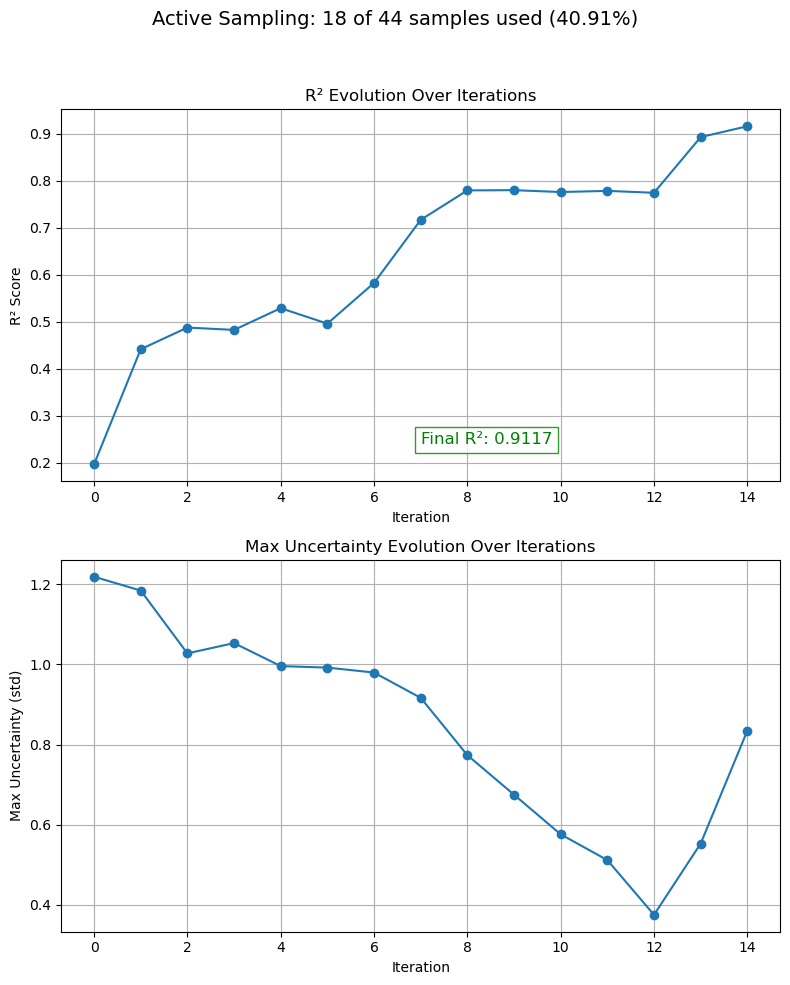

In [40]:
import matplotlib.pyplot as plt

def print_iteration_log(results, total_data_count):
    final_samples = results['total_samples_used']
    percent_used = final_samples / total_data_count * 100
    print(f"Total Data Available: {total_data_count}")
    print(f"Total Samples Used: {final_samples} ({percent_used:.2f}%)")
    print("\nIteration Log:")
    for log in results['iteration_log']:
        print(f"Iteration {log['iteration']}: {log['num_samples']} samples, "
              f"Max Uncertainty: {log['max_uncertainty']:.4f}, R²: {log['r2']:.4f}")
    print(f"\nFinal R² Score: {results['final_r2']:.4f}")

def plot_active_sampling_results(results, total_data_count):
    iterations = [log['iteration'] for log in results['iteration_log']]
    r2_values = [log['r2'] for log in results['iteration_log']]
    uncertainties = [log['max_uncertainty'] for log in results['iteration_log']]
    
    final_samples = results['total_samples_used']
    percent_used = final_samples / total_data_count * 100

    fig, ax = plt.subplots(2, 1, figsize=(8, 10))
    
    ax[0].plot(iterations, r2_values, marker='o', linestyle='-')
    ax[0].set_title('R² Evolution Over Iterations')
    ax[0].set_xlabel('Iteration')
    ax[0].set_ylabel('R² Score')
    ax[0].grid(True)
    ax[0].text(0.5, 0.1, f'Final R²: {results["final_r2"]:.4f}', 
               transform=ax[0].transAxes, fontsize=12, color='green',
               bbox=dict(facecolor='white', alpha=0.8, edgecolor='green'))
    
    
    ax[1].plot(iterations, uncertainties, marker='o', linestyle='-')
    ax[1].set_title('Max Uncertainty Evolution Over Iterations')
    ax[1].set_xlabel('Iteration')
    ax[1].set_ylabel('Max Uncertainty (std)')
    ax[1].grid(True)
    
    plt.suptitle(f'Active Sampling: {final_samples} of {total_data_count} samples used ({percent_used:.2f}%)', fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

total_data_count = X.shape[0]  # For example, if X has 44 rows

print_iteration_log(results, total_data_count)
plot_active_sampling_results(results, total_data_count)


### Gaussian Process Regression - Full dataset Testing

#### Active Sampling Model Execution

In this section, we execute our active sampling models over all parameter combinations. We provide two variants:
- **Basic Active Sampling Loop:** The standard loop that iteratively selects samples based on maximum uncertainty.
- **Active Sampling Loop with Stagnant Iterations Stop:** An enhanced loop that also monitors `R²` improvements and stops if the model's performance stagnates while uncertainty is moderately low.

This section prepares the results for each parameter combination by running the appropriate active sampling function and collecting key metrics such as the final R², total samples used, and iteration logs.


In [26]:
%%capture
%pip install tqdm

In [56]:
import warnings
from sklearn.exceptions import ConvergenceWarning
from tqdm import tqdm

def run_active_sampling_basic(params_list, data, sort=False, verbose=False, **hyperparams):
    results_list = []
    if not verbose:
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
    
    for i, param in enumerate(tqdm(params_list, desc="Running basic active sampling", disable=verbose)):
        X, y, scaler, reverse_scaling = prepare_training_data(param, data, sort=sort)
        total_data_count = X.shape[0] 
        
        result = active_sampling_loop(X, y, **hyperparams)
        result['params'] = param
        result['total_data_count'] = total_data_count
        results_list.append(result)
        if verbose:
            print(f"Completed parameter {i+1}/{len(params_list)}: R² = {result['final_r2']:.4f}, Samples = {result['total_samples_used']} of {X.shape[0]}")
            
    warnings.filterwarnings("default", category=ConvergenceWarning)

    return results_list

basic_hyperparams = {
    "max_iterations": 15,
    "uncertainty_threshold": 0.05,
}

results_basic = run_active_sampling_basic(
params_mostData[:3], data_filtered, 
verbose=True,
**basic_hyperparams
)

Completed parameter 1/3: R² = 0.9094, Samples = 18 of 44
Completed parameter 2/3: R² = 0.7756, Samples = 18 of 43


/opt/anaconda3/envs/DS-101-Final/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/anaconda3/envs/DS-101-Final/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/anaconda3/envs/DS-101-Final/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/anaconda3/envs/DS-101-Final/l

Completed parameter 3/3: R² = 0.9999, Samples = 18 of 30


/opt/anaconda3/envs/DS-101-Final/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


In [42]:

def run_active_sampling_stagnant(params_list, data, sort=False ,verbose=False, **hyperparams):
    results_list = []
    if not verbose:
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
    
    for i, param in enumerate(tqdm(params_list, desc="Running stagnant active sampling", disable=verbose)):
        X, y, scaler, reverse_scaling = prepare_training_data(param, data, sort=sort)
        total_data_count = X.shape[0] 
        
        result = active_sampling_loop_with_stagnant_iterations_stop(X, y, **hyperparams)
        result['params'] = param
        result['total_data_count'] = total_data_count 
        results_list.append(result)
        if verbose:
            print(f"Completed parameter {i+1}/{len(params_list)}: R² = {result['final_r2']:.4f}, Samples = {result['total_samples_used']} of {total_data_count}")
    
    warnings.filterwarnings("default", category=ConvergenceWarning)

    return results_list

stagnant_hyperparams = {
    "max_iterations": 15,
    "uncertainty_threshold": 0.05,
    "higher_uncertainty_threshold": 0.1,
    "r2_improvement_threshold": 1e-4,
    "max_stagnant_iterations": 3
}

results_stagnant = run_active_sampling_stagnant(
params_mostData[:3], data_filtered,
verbose =True,
**stagnant_hyperparams
)

/opt/anaconda3/envs/DS-101-Final/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Completed parameter 1/3: R² = 0.9117, Samples = 18 of 44
Completed parameter 2/3: R² = 0.7719, Samples = 18 of 43


/opt/anaconda3/envs/DS-101-Final/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/anaconda3/envs/DS-101-Final/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/anaconda3/envs/DS-101-Final/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/anaconda3/envs/DS-101-Final/l

Completed parameter 3/3: R² = 0.9999, Samples = 18 of 30


#### Results Visualization & Preliminary Conclusions



##### Visualization 


In this cell, we visualize the aggregated results. The visualization function now accepts:
- `loop_type`: A string indicating the active sampling variant (e.g., "Basic Active Loop" or "Stagnant Active Loop").
- `hyperparams`: A dictionary of hyperparameter values used for the active sampling loop.

The function then creates a title that includes these hyperparameter values and displays three bar charts:
- Final `R²` scores.
- Total samples used.
- Data utilization percentages (samples used as a percentage of total available data).



In [57]:
import matplotlib.pyplot as plt

def visualize_aggregated_results(results_list, loop_type, hyperparams):
    title_str = f"{loop_type} Results"
    
    hyperparams_items = [f"{k}: {v}" for k, v in hyperparams.items()]
    hyperparams_str = ""
    for i in range(0, len(hyperparams_items), 3):
        chunk = " | ".join(hyperparams_items[i:i+3])
        hyperparams_str += chunk + ("\n" if i + 3 < len(hyperparams_items) else "")
    
    final_r2_list = [r['final_r2'] for r in results_list]
    samples_used_list = [r['total_samples_used'] for r in results_list]
    total_data_counts = [r['total_data_count'] for r in results_list]
    data_utilization_list = [ (used / total) * 100 for used, total in zip(samples_used_list, total_data_counts)]
    
    n = len(results_list)
    indices = range(n)
    
    avg_r2 = sum(final_r2_list) / n
    avg_samples = sum(samples_used_list) / n
    avg_utilization = sum(data_utilization_list) / n
    
    # Create subplots for the aggregated metrics.
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Bar chart for final R².
    axes[0].bar(indices, final_r2_list, color='skyblue')
    axes[0].axhline(avg_r2, color='red', linestyle='--', label=f'Avg R² = {avg_r2:.4f}')
    axes[0].set_xlabel('Parameter Combination Index')
    axes[0].set_ylabel('Final R²')
    axes[0].set_title('Final R² for Each Combination')
    axes[0].legend()
    
    # Bar chart for total samples used.
    axes[1].bar(indices, samples_used_list, color='lightgreen')
    axes[1].axhline(avg_samples, color='red', linestyle='--', label=f'Avg Samples = {avg_samples:.2f}')
    axes[1].set_xlabel('Parameter Combination Index')
    axes[1].set_ylabel('Total Samples Used')
    axes[1].set_title('Samples Used per Combination')
    axes[1].legend()
    
    # Bar chart for data utilization (%).
    axes[2].bar(indices, data_utilization_list, color='plum')
    axes[2].axhline(avg_utilization, color='red', linestyle='--', label=f'Avg Utilization = {avg_utilization:.2f}%')
    axes[2].set_xlabel('Parameter Combination Index')
    axes[2].set_ylabel('Data Utilization (%)')
    axes[2].set_title('Data Utilization per Combination')
    axes[2].legend()
    
    # Set a prominent super-title at the top.
    plt.suptitle(title_str, fontsize=20, fontweight='bold', color='navy', y=0.98)
    
    # Add a centered hyperparameters container below the title.
    # This container is placed at y=0.93 and is horizontally centered (x=0.5).
    plt.gcf().text(0.5, 0.85, f"Hyperparameters:\n\n{hyperparams_str}", 
                   fontsize=12, ha='center', va='center',
                   bbox=dict(facecolor='lightgrey', alpha=0.6, boxstyle='round,pad=0.5'))
    
    # Adjust the layout so that subplots start below the hyperparameters container.
    plt.tight_layout(rect=[0, 0, 1, 0.83])
    plt.show()
    
    print(f"Average Final R²: {avg_r2:.4f}")
    print(f"Average Samples Used: {avg_samples:.2f}")
    print(f"Average Data Utilization: {avg_utilization:.2f}%")

In [59]:
X.head()

,Discount Code,Available Rooms,Hotel Stars,DayDiff,Checkin_Date_num,WeekDay_num
12619,3,-1.137934,5,-0.175316,-0.175316,3
12620,3,-1.137934,5,-0.058439,-0.058439,4
4127,3,-1.137934,5,-0.175316,-0.175316,3
4128,3,-1.137934,5,-0.058439,-0.058439,4
12617,3,1.075553,5,-0.409071,-0.409071,1


Running basic active sampling: 100%|██████████| 40/40 [00:28<00:00,  1.39it/s]


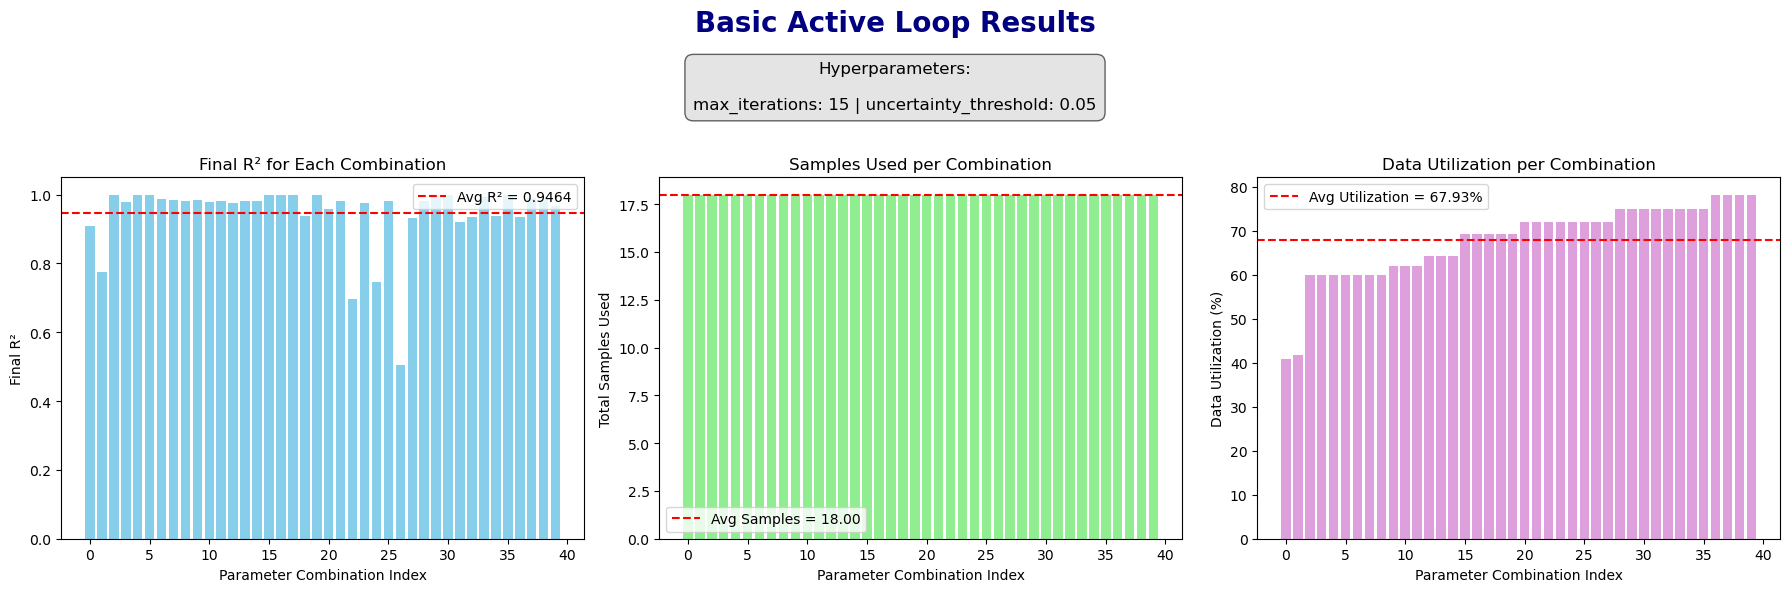

Average Final R²: 0.9464
Average Samples Used: 18.00
Average Data Utilization: 67.93%


In [58]:
results_basic = run_active_sampling_basic(params_mostData, data_filtered, verbose=False, **basic_hyperparams)
visualize_aggregated_results(results_basic, "Basic Active Loop", basic_hyperparams)

Running stagnant active sampling: 100%|██████████| 40/40 [00:32<00:00,  1.24it/s]


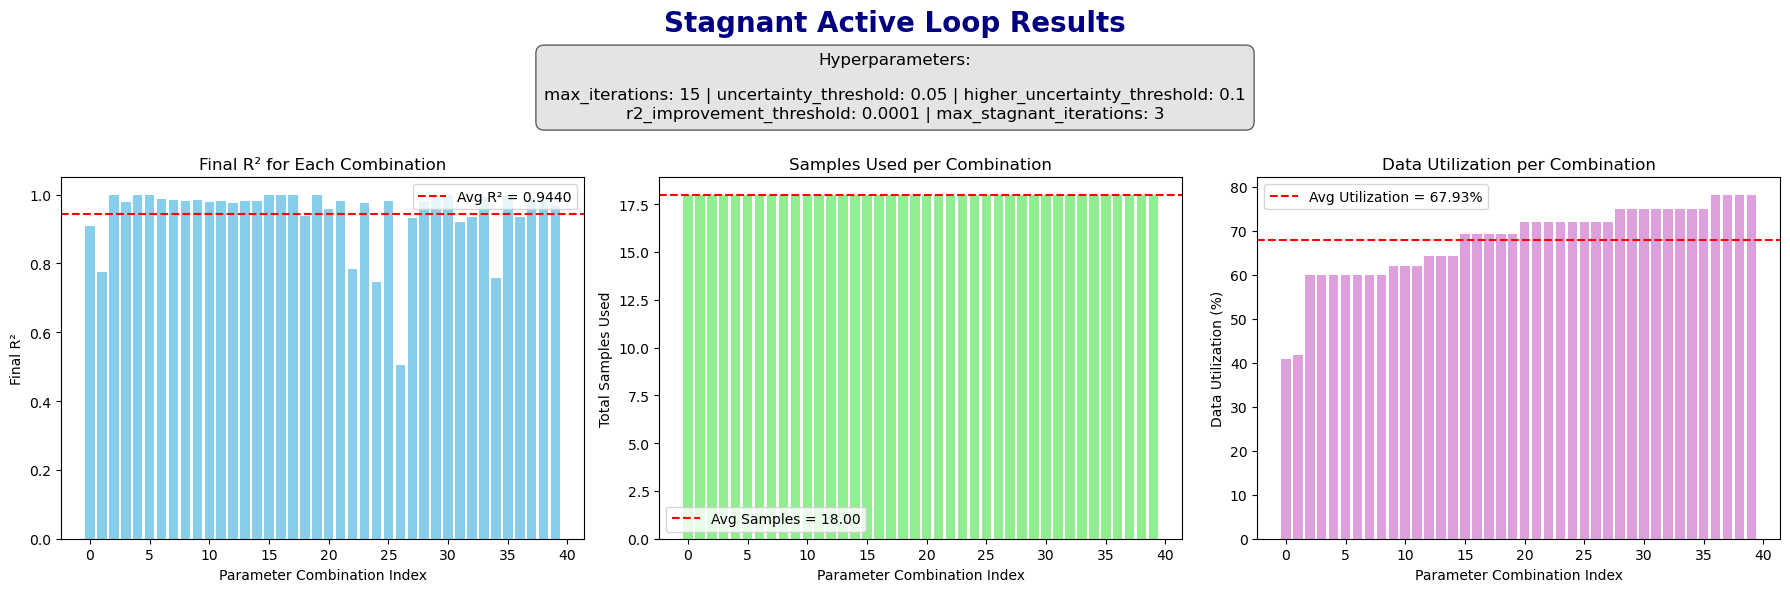

Average Final R²: 0.9440
Average Samples Used: 18.00
Average Data Utilization: 67.93%


In [60]:
results_stagnant = run_active_sampling_stagnant(params_mostData, data_filtered, verbose=False, **stagnant_hyperparams)
visualize_aggregated_results(results_stagnant, "Stagnant Active Loop", stagnant_hyperparams)

##### Preliminary Conclusions

**Results**:

![Basic results updated](./images/step-4-Basic-initial-results.png)

![Stagnant results](./images/step-4-stagnat-initial-results.png)  

**Basic V.S. Stagnant**

- **Basic Active Sampling Loop:**
  - **Robustness:** Tends to use around 18 samples per parameter combination, yielding high `R²` scores (often 1.0000).
  - **Efficiency:** Uses more data, which may be unnecessary in cases with abundant information.

- **Stagnant Active Sampling Loop:**
  - **Efficiency:** Stops early when `R²` improvement stagnates, generally using fewer samples (between 11–16) and still achieving high performance in most cases.
  - **Risks:** In some cases (e.g., parameter combinations with very few total data points), the loop stops after only 3 samples, leading to negative `R²` values and clear underfitting.

 **Outliers and Data Issues**

- **Outlier Cases:**  
  Some parameter combinations consistently use only 3 samples and report poor performance (e.g., negative `R²`). These cases likely represent scenarios where the available data is sparse or noisy, right now its looking like  the most promising direction to investigate and improve.

- **Implication:**  
  Relying solely on the stagnant loop's stopping criterion can result in premature termination. A minimum sample threshold may be necessary to ensure that the model has enough data to learn meaningful patterns.

 **Next Steps**

1. **Revisit the Data:**  
   Analyze the outlier parameter combinations with low total data counts. Determine if these cases should be treated differently or if more data can be acquired.

2. **Implement a Minimum Sample Threshold:**  
   Adjust the stagnant loop to enforce a minimum number of samples (e.g., at least 5 or 7 samples) before allowing early termination (probably most promising result).

3. **Hyperparameter Tuning:**  
   Experiment with different settings for the uncertainty thresholds and maximum stagnant iterations to balance efficiency and robustness. Fine-tuning may reduce instances where the model stops too early.


### Final Optimization and Data Revision

In this section, would try to improve our results and address the points raised in the [preliminary conclusions](#preliminary-conclusions)

- Revisit the Data
- Implement a Minimum Sample Threshold
- Hyperparameter Tuning

#### Revisit the data

##### Revisit Parameter Sampling


Here we re-calculate the parameter combinations using our two strategies:
- **onePerHotel:** For each hotel, we select the combination (of `Snapshot Date`, `Hotel Name`, and `Discount Code`) with the highest transaction count.
- **mostData:** We select the top 40 overall combinations based on transaction counts.

We then display these results in a table (including the transaction counts) so we can review the distribution and identify any potential outliers in data availability.


In [32]:
grouped = data_filtered.groupby(
    ['Snapshot Date', 'Hotel Name', 'Discount Code']
).size().reset_index(name='transaction_count')

onePerHotel = (
    grouped.sort_values(['Hotel Name', 'transaction_count'], ascending=[True, False])
    .groupby('Hotel Name')
    .first()
    .reset_index()
)
onePerHotel = onePerHotel.sort_values('transaction_count', ascending=False).head(40)

mostData = grouped.sort_values('transaction_count', ascending=False).head(40)

print("One Per Hotel (Top 40) Parameter Combinations with Transaction Counts:")
display(onePerHotel)

print("\nMost Data (Top 40) Parameter Combinations with Transaction Counts:")
display(mostData)


One Per Hotel (Top 40) Parameter Combinations with Transaction Counts:


,Hotel Name,Snapshot Date,Discount Code,transaction_count
339,Park Hyatt New York,2015-07-22,3,44
325,Newark Liberty International Airport Marriott,2015-07-22,3,30
468,The New York EDITION,2015-07-27,2,30
168,Hampton Inn Madison Square Garden Area Hotel,2015-07-23,4,26
431,The Carlyle A Rosewood Hotel,2015-12-20,4,26
540,Wyndham Garden Brooklyn Sunset Park,2015-10-28,3,24
172,Hampton Inn Manhattan Times Square South,2015-07-22,2,24
521,Viceroy New York,2015-12-29,4,22
534,Westin New York at Times Square,2015-10-21,2,21
290,Magnuson Convention Center Hotel,2015-07-27,2,20



Most Data (Top 40) Parameter Combinations with Transaction Counts:


,Snapshot Date,Hotel Name,Discount Code,transaction_count
1684,2015-07-22,Park Hyatt New York,3,44
1683,2015-07-22,Park Hyatt New York,2,43
1682,2015-07-22,Park Hyatt New York,1,30
3312,2015-07-27,The New York EDITION,2,30
1967,2015-07-23,Newark Liberty International Airport Marriott,3,30
1676,2015-07-22,Newark Liberty International Airport Marriott,3,30
3984,2015-07-29,The New York EDITION,3,30
3983,2015-07-29,The New York EDITION,2,30
3313,2015-07-27,The New York EDITION,3,30
2630,2015-07-25,The New York EDITION,2,29


This looks solid to me, shows again the for maximum data we rather stick to Most Data params instead of One Per Hotel

##### Investigating Valid Data and Outliers for Parameter Combinations

Here, we further analyze the data returned by `load_relevant_data` for each parameter combination. For each combination, we compute:
- Total rows (number of transactions)
- Unique counts for WeekDays, Snapshot IDs, Check-in Dates, and Available Rooms
- Weekend count and Holiday-Connected count (using US holidays for 2014–2016, with a check for a holiday occurring within 3 days before or 1 day after the check-in date)
- Data range (from snapshot date to snapshot date + 30 days)
- **Price Metrics:**
  - Minimum and maximum Discount Price
  - Price range as a percentage
  - An array of price points (each price point is `[price, showcount]`)

We then split the parameter combinations into two groups (Good Predictions vs. Suspected Outliers) based on the final `R²` value and display an average comparison table.

In [33]:
%%capture
%pip install holidays

In [34]:
import pandas as pd
import holidays

# Create a US holidays object for the years 2014-2016.
us_holidays = holidays.US(years=[2014, 2015, 2016])

def is_connected_to_holiday(checkin_date, window_before=3, window_after=1):
    checkin_date = pd.to_datetime(checkin_date)
    start_window = checkin_date - pd.Timedelta(days=window_before)
    end_window = checkin_date + pd.Timedelta(days=window_after)
    for holiday_date in us_holidays.keys():
        holiday_ts = pd.to_datetime(holiday_date)
        if start_window <= holiday_ts <= end_window:
            return True
    return False

summary_metrics = []
for result in results_stagnant:  # (Use results from the stagnant or basic loop as needed)
    param = result['params']
    df_subset = load_relevant_data(param, data_filtered)
    total_rows = df_subset.shape[0]
    
    unique_weekdays = df_subset['WeekDay'].nunique() if 'WeekDay' in df_subset.columns else None
    unique_snapshot_ids = df_subset['Snapshot ID'].nunique() if 'Snapshot ID' in df_subset.columns else None
    unique_checkin_dates = df_subset['Checkin Date'].nunique() if 'Checkin Date' in df_subset.columns else None
    unique_rooms = df_subset['Available Rooms'].nunique() if 'Available Rooms' in df_subset.columns else None
    
    weekend_count = df_subset[df_subset['WeekDay'].isin(["Friday", "Saturday", "Sunday"])].shape[0]
    holiday_connected_count = df_subset[df_subset['Checkin Date'].apply(is_connected_to_holiday)].shape[0]
    
    snapshot_dt = pd.to_datetime(param['Snapshot Date'])
    data_range = f"{snapshot_dt.strftime('%Y-%m-%d')} - {(snapshot_dt + pd.Timedelta(days=30)).strftime('%Y-%m-%d')}"
    
    # Price metrics
    if total_rows > 0:
        discount_price_min = df_subset["Discount Price"].min()
        discount_price_max = df_subset["Discount Price"].max()
        discount_price_mean = df_subset["Discount Price"].mean()
        discount_price_std = df_subset["Discount Price"].std()
        price_range_percent = ((discount_price_max - discount_price_min) / discount_price_min) * 100 if discount_price_min != 0 else None
        price_counts = df_subset["Discount Price"].value_counts().sort_index()
        price_points = [[price, count] for price, count in price_counts.items()]
    else:
        discount_price_min = discount_price_max = discount_price_mean = discount_price_std = price_range_percent = None
        price_points = []
    
    param_key = f"{param['Snapshot Date']} | {param['Hotel Name']} | {param['Discount Code']}"
    
    summary_metrics.append({
        "Parameter": param_key,
        "Final R²": result['final_r2'],
        "Total Rows": total_rows,
        "Unique WeekDays": unique_weekdays,
        "Unique Snapshot IDs": unique_snapshot_ids,
        "Unique Checkin Dates": unique_checkin_dates,
        "Unique Rooms": unique_rooms,
        "Weekend Count": weekend_count,
        "Holiday Connected Count": holiday_connected_count,
        "Data Range": data_range,
        "Price Points": price_points,
        "Price Points length": len(price_points),
    })

df_metrics = pd.DataFrame(summary_metrics)

# Split into groups based on final R² (good predictions vs. suspected outliers)
df_predicting_well = df_metrics[df_metrics["Final R²"] >= 0]
df_outliers = df_metrics[df_metrics["Final R²"] < 0]

# Compute averages for numeric columns (price metrics will be averaged only for percentage metrics)
avg_good = df_predicting_well.mean(numeric_only=True)
avg_bad = df_outliers.mean(numeric_only=True)

avg_table = pd.DataFrame({"Good Predictions": avg_good, "Bad Predictions": avg_bad})
print("Average Metrics Comparison:")
display(avg_table)

print("\nDetailed Metrics for Good Predictions:")
display(df_predicting_well)
print("\nDetailed Metrics for Suspected Outliers:")
display(df_outliers)

Average Metrics Comparison:


,Good Predictions,Bad Predictions
Final R²,0.986878,NaN
Total Rows,27.050000,NaN
Unique WeekDays,6.550000,NaN
Unique Snapshot IDs,1.300000,NaN
Unique Checkin Dates,22.825000,NaN
Unique Rooms,6.150000,NaN
Weekend Count,10.025000,NaN
Holiday Connected Count,2.900000,NaN
Price Points length,5.625000,NaN



Detailed Metrics for Good Predictions:


,Parameter,Final R²,Total Rows,Unique WeekDays,Unique Snapshot IDs,Unique Checkin Dates,Unique Rooms,Weekend Count,Holiday Connected Count,Data Range,Price Points,Price Points length
0,2015-07-22 00:00:00 | Park Hyatt New York | 3,0.911719,44,7,2,23,11,17,0,2015-07-22 - 2015-08-21,"[[3255, 4], [3275, 6], [3400, 1], [3455, 22], ...",5
1,2015-07-22 00:00:00 | Park Hyatt New York | 2,0.771914,43,7,2,22,8,18,0,2015-07-22 - 2015-08-21,"[[3255, 6], [3275, 8], [3400, 2], [3455, 14], ...",5
2,2015-07-22 00:00:00 | Park Hyatt New York | 1,0.999886,30,7,2,16,7,12,0,2015-07-22 - 2015-08-21,"[[3378, 4], [3588, 6], [3650, 2], [3678, 12], ...",5
3,2015-07-27 00:00:00 | The New York EDITION | 2,0.997681,30,7,1,30,1,12,0,2015-07-27 - 2015-08-26,"[[1900, 4], [1925, 4], [1950, 5], [1951, 4], [...",7
4,2015-07-23 00:00:00 | Newark Liberty Internati...,0.999629,30,4,2,15,1,0,0,2015-07-23 - 2015-08-22,"[[785, 2], [855, 6], [962, 2], [970, 2], [991,...",9
5,2015-07-22 00:00:00 | Newark Liberty Internati...,0.999721,30,4,2,15,1,0,0,2015-07-22 - 2015-08-21,"[[785, 2], [828, 2], [846, 4], [944, 2], [956,...",13
6,2015-07-29 00:00:00 | The New York EDITION | 3,0.998093,30,7,1,30,1,13,0,2015-07-29 - 2015-08-28,"[[1900, 4], [1925, 5], [1950, 5], [1951, 4], [...",7
7,2015-07-29 00:00:00 | The New York EDITION | 2,0.998138,30,7,1,30,1,13,0,2015-07-29 - 2015-08-28,"[[1900, 5], [1925, 5], [1950, 4], [1951, 4], [...",7
8,2015-07-27 00:00:00 | The New York EDITION | 3,0.997766,30,7,1,30,1,12,0,2015-07-27 - 2015-08-26,"[[1900, 5], [1925, 4], [1950, 4], [1951, 5], [...",7
9,2015-07-25 00:00:00 | The New York EDITION | 2,0.997864,29,7,1,29,1,12,0,2015-07-25 - 2015-08-24,"[[1900, 4], [1925, 4], [1950, 4], [1951, 4], [...",7



Detailed Metrics for Suspected Outliers:


,Parameter,Final R²,Total Rows,Unique WeekDays,Unique Snapshot IDs,Unique Checkin Dates,Unique Rooms,Weekend Count,Holiday Connected Count,Data Range,Price Points,Price Points length



 **Average Metrics Comparison**

| Metric                      | Good Predictions | Bad Predictions  |
|-----------------------------|------------------|------------------|
| Final R²                    | 0.999862         | -0.603804        |
| Total Rows                  | 27.677419        | 24.888889        |
| Unique WeekDays             | 6.419355         | 7.000000         |
| Unique Snapshot IDs         | 1.354839         | 1.111111         |
| Unique Checkin Dates        | 22.580645        | 23.666667        |
| Unique Rooms                | 5.225806         | 9.333333         |
| Weekend Count               | 9.741935         | 11.000000        |
| Holiday Connected Count     | 2.548387         | 4.111111         |
| Price Points Length         | 6.419355         | 2.888889         |

*Note: The current dataset used for model training did not include the "holiday connected" feature. The holiday connected count is computed solely for this analysis.*

**Key Observations**

- **Overall Quality:**  
  - **Similarities:**  
  Both groups have comparable totals for rows, unique weekdays, snapshot IDs, and check-in dates.

  - **Differences:**  
  The outlier group shows notably higher variability in unique rooms (9.33 vs. 5.23) and a higher holiday connected count (4.11 vs. 2.55).

- **Outlier Behavior: Two Subgroups **  
  1. **The Carlyle A Rosewood Group:**  
   - **Performance:** Final R² values are very low or negative.  
   - **Price Data:** Limited price variability (there are only unique 2 price points per data set), with many entries concentrated at one price.  
   - **Other Metrics:** Higher unique rooms and holiday connected counts suggest inconsistencies in the data for this hotel.

  2. **The New York EDITION and Park Hyatt New York Group:**  
    - **Performance:** Despite being flagged as outliers, these cases exhibit high final R² (good model performance).  
    - **Price Data:** They display greater diversity in price points and more consistent room data, which might be influenced by market factors not captured in the current model.



**Next Steps and Conclusions**

- The overall data quality appears acceptable. Although adding the holiday connected feature is an option, my intuition is that it may not significantly improve the model—and could potentially add more noise.
- The limited price variability in the Carlyle A Rosewood subgroup is a promising direction for further investigation.
- The immediate next step should be to examine the algorithm's stopping criteria. In particular, we need to understand why the active sampling stops after only 3 requests and explore the effects of modifying this behavior to request more data points before termination.



#### Why do we stop? (Minimum Sample Threshold)

**Questions**: 
- Why did the model stop sampling after 3 iterations? 
- what would happen if we set a minimum number of iterations (higher)?

##### Debugging the Stop



In this section, we investigate why the basic active sampling loop stops after only a few iterations. We focus on three parameter combinations from the suspected outlier group:
- **params_mostData[9]** (The New York EDITION)
- **params_mostData[21]** (The Carlyle A Rosewood)
- **params_mostData[29]** (Park Hyatt New York)

We use a debug version of the active sampling loop that prints:
- The training and candidate indices at each iteration.
- The uncertainty values for each candidate.
- The final training Data.
- The maximum uncertainty and the chosen candidate index.
- The current `R²` score.

This information should shed light on why the loop is stopping early, helping us determine if a higher minimum sample threshold might be necessary.


In [35]:
def active_sampling_loop_debug_table(X, y, max_iterations=10, uncertainty_threshold=0.05, initial_sample_indices=None):
    n_samples = X.shape[0]
    if initial_sample_indices is None:
        initial_sample_indices = [0, n_samples // 2, n_samples - 1]
    
    training_indices = set(initial_sample_indices)
    candidate_indices = set(range(n_samples)) - training_indices
    iteration_log = []
    
    for iteration in range(max_iterations):
        X_train = X.iloc[sorted(list(training_indices))]
        y_train = y.iloc[sorted(list(training_indices))]

        model = initialize_model()
        model.fit(X_train, y_train)
        
        candidate_list = sorted(list(candidate_indices))
        X_candidates = X.iloc[candidate_list]
        y_pred_candidates, std_candidates = model.predict(X_candidates, return_std=True)
        
        max_std = np.max(std_candidates)
        chosen_candidate_idx = candidate_list[np.argmax(std_candidates)]
        
        y_pred_full = model.predict(X)
        current_r2 = r2_score(y, y_pred_full)
        
        iteration_details = {
            "Iteration": iteration,
            "Training Indices": ", ".join(map(str, sorted(training_indices))),
            "Candidate Indices": ", ".join(map(str, sorted(candidate_indices))),
            "Candidate Uncertainties": str(np.round(std_candidates, 4).tolist()),
            "Max Uncertainty": round(max_std, 4),
            "Chosen Candidate": chosen_candidate_idx,
            "Current R²": round(current_r2, 4)
        }
        iteration_log.append(iteration_details)
        
        if max_std < uncertainty_threshold:
            break
        
        training_indices.add(chosen_candidate_idx)
        candidate_indices.remove(chosen_candidate_idx)
    
    X_final = X.iloc[sorted(list(training_indices))]
    y_final = y.iloc[sorted(list(training_indices))]
    final_model = initialize_model()
    final_model.fit(X_final, y_final)
    final_predictions = final_model.predict(X)
    final_r2 = r2_score(y, final_predictions)
    
    final_details = {
        "Final R²": round(final_r2, 4),
        "Total Samples Used": len(training_indices)
    }
    
    print("Iteration Details:")
    display(pd.DataFrame(iteration_log))
    print("\nFinal Details:")
    display(pd.DataFrame([final_details]))
    
    print("\nFinal Training Data (first 10 rows):")
    display(X_final.head(10))
    print("Final Training Target (first 10 rows):")
    display(y_final.head(10))
    
    return {
        'final_model': final_model,
        'final_predictions': final_predictions,
        'final_r2': final_r2,
        'iteration_log': iteration_log,
        'total_samples_used': len(training_indices)
    }

# Debug the basic loop for selected parameters from the suspected outlier group.
params_to_debug = [params_mostData[9], params_mostData[21], params_mostData[29]]

for param in params_to_debug:
    print("--------------------------------------------------")
    print(f"Debugging for parameter: {param['Snapshot Date']} | {param['Hotel Name']} | {param['Discount Code']}")
    X_debug, y_debug, scaler, reverse_scaling = prepare_training_data(param, data_filtered)
    result_debug = active_sampling_loop_debug_table(X_debug, y_debug, max_iterations=15, uncertainty_threshold=0.05)
    print("--------------------------------------------------\n")


--------------------------------------------------
Debugging for parameter: 2015-07-25 00:00:00 | The New York EDITION | 2
Iteration Details:


,Iteration,Training Indices,Candidate Indices,Candidate Uncertainties,Max Uncertainty,Chosen Candidate,Current R²
0,0,"0, 14, 28","1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15,...","[1.2173, 0.8452, 1.1726, 0.7154, 1.2184, 1.027...",1.2191,18,0.4704
1,1,"0, 14, 18, 28","1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15,...","[1.0566, 0.7592, 1.028, 0.6496, 1.0274, 0.9143...",1.0593,21,0.5152
2,2,"0, 14, 18, 21, 28","1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15,...","[0.9906, 0.7036, 0.9613, 0.5998, 0.9636, 0.851...",0.9906,1,0.5028
3,3,"0, 1, 14, 18, 21, 28","2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16...","[0.8918, 0.8924, 0.8026, 0.8114, 1.0366, 0.984...",1.1105,9,0.7017
4,4,"0, 1, 9, 14, 18, 21, 28","2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 15, 16, 1...","[0.7648, 0.7697, 0.6261, 0.7023, 0.6341, 0.729...",1.0270,25,0.7307
5,5,"0, 1, 9, 14, 18, 21, 25, 28","2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 15, 16, 1...","[0.2389, 0.2408, 0.1881, 0.1962, 0.1697, 0.188...",0.4287,20,0.9706
6,6,"0, 1, 9, 14, 18, 20, 21, 25, 28","2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 15, 16, 1...","[0.1787, 0.1835, 0.1525, 0.1526, 0.1352, 0.148...",0.3421,24,0.9872
7,7,"0, 1, 9, 14, 18, 20, 21, 24, 25, 28","2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 15, 16, 1...","[0.1381, 0.1454, 0.1282, 0.1233, 0.1141, 0.120...",0.1836,13,0.9946
8,8,"0, 1, 9, 13, 14, 18, 20, 21, 24, 25, 28","2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 15, 16, 17, 1...","[0.0965, 0.0989, 0.1148, 0.1127, 0.0927, 0.096...",0.1412,11,0.9955
9,9,"0, 1, 9, 11, 13, 14, 18, 20, 21, 24, 25, 28","2, 3, 4, 5, 6, 7, 8, 10, 12, 15, 16, 17, 19, 2...","[0.093, 0.0938, 0.0835, 0.109, 0.0848, 0.0932,...",0.1350,8,0.9956



Final Details:


,Final R²,Total Samples Used
0,0.9979,18



Final Training Data (first 10 rows):


,Original Price,Discount Code,Available Rooms,Hotel Stars,DayDiff,Checkin_Date_num,WeekDay_num
33921,-1.061446,2,0.0,5,1.314751,1.314751,4
33900,-1.061446,2,0.0,5,-1.195229,-1.195229,4
33907,-1.061446,2,0.0,5,-0.358569,-0.358569,4
33898,-1.061446,2,0.0,5,-1.434274,-1.434274,2
33912,-1.061446,2,0.0,5,0.239046,0.239046,2
33919,-1.061446,2,0.0,5,1.075706,1.075706,2
33908,0.122474,2,0.0,5,-0.239046,-0.239046,5
33922,0.122474,2,0.0,5,1.434274,1.434274,5
33901,0.122474,2,0.0,5,-1.075706,-1.075706,5
33897,0.122474,2,0.0,5,-1.553797,-1.553797,1


Final Training Target (first 10 rows):


33921   -1.431884
33900   -1.431884
33907   -1.431884
33898   -0.469775
33912   -0.469775
33919   -0.469775
33908   -0.450532
33922   -0.450532
33901   -0.450532
33897    0.492334
Name: Discount Price, dtype: float64

--------------------------------------------------

--------------------------------------------------
Debugging for parameter: 2016-01-01 00:00:00 | The Carlyle A Rosewood Hotel | 2


/opt/anaconda3/envs/DS-101-Final/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iteration Details:


,Iteration,Training Indices,Candidate Indices,Candidate Uncertainties,Max Uncertainty,Chosen Candidate,Current R²
0,0,"0, 12, 24","1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15,...","[1.7289, 1.7289, 1.7289, 1.7289, 1.7289, 1.728...",1.7289,1,-0.5097
1,1,"0, 1, 12, 24","2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16...","[1.5881, 1.5881, 1.5881, 1.5881, 1.5881, 1.588...",1.5881,2,0.0149
2,2,"0, 1, 2, 12, 24","3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 1...","[0.3642, 0.6734, 0.9265, 0.9022, 0.9544, 0.935...",1.1511,17,0.9420
3,3,"0, 1, 2, 12, 17, 24","3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 1...","[0.2406, 0.3769, 0.5443, 0.575, 0.5814, 0.4391...",0.7141,22,0.9889
4,4,"0, 1, 2, 12, 17, 22, 24","3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 1...","[0.1605, 0.2398, 0.3556, 0.367, 0.3767, 0.2562...",0.4535,20,0.9961
5,5,"0, 1, 2, 12, 17, 20, 22, 24","3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 1...","[0.1064, 0.1355, 0.1771, 0.1355, 0.1301, 0.108...",0.1771,5,0.9998
6,6,"0, 1, 2, 5, 12, 17, 20, 22, 24","3, 4, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 18, ...","[0.0707, 0.0761, 0.1112, 0.1123, 0.0953, 0.075...",0.1454,19,0.9998
7,7,"0, 1, 2, 5, 12, 17, 19, 20, 22, 24","3, 4, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 18, ...","[0.0651, 0.0707, 0.0981, 0.1014, 0.0855, 0.070...",0.1183,23,0.9999
8,8,"0, 1, 2, 5, 12, 17, 19, 20, 22, 23, 24","3, 4, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 18, 21","[0.0832, 0.0903, 0.123, 0.1276, 0.108, 0.0898,...",0.1276,7,0.9998
9,9,"0, 1, 2, 5, 7, 12, 17, 19, 20, 22, 23, 24","3, 4, 6, 8, 9, 10, 11, 13, 14, 15, 16, 18, 21","[0.0784, 0.0862, 0.0965, 0.0794, 0.0808, 0.072...",0.1210,13,0.9999



Final Details:


,Final R²,Total Samples Used
0,1.0,18



Final Training Data (first 10 rows):


,Original Price,Discount Code,Available Rooms,Hotel Stars,DayDiff,Checkin_Date_num,WeekDay_num
175945,-0.294884,2,0.046575,5,-1.490549,-1.490549,5
175967,-0.294884,2,1.094504,5,1.417314,1.417314,4
175966,-0.294884,2,0.978068,5,1.309615,1.309615,3
175964,-0.294884,2,0.978068,5,1.094218,1.094218,1
175963,-0.294884,2,0.861631,5,0.986519,0.986519,0
175962,-0.294884,2,0.628758,5,0.878821,0.878821,6
175959,-0.294884,2,-0.652045,5,0.017232,0.017232,5
175958,-0.294884,2,-0.652045,5,-0.090467,-0.090467,4
175968,-0.294884,2,1.443814,5,1.525012,1.525012,5
175954,-0.294884,2,0.628758,5,-0.521261,-0.521261,0


Final Training Target (first 10 rows):


175945   -0.294884
175967   -0.294884
175966   -0.294884
175964   -0.294884
175963   -0.294884
175962   -0.294884
175959   -0.294884
175958   -0.294884
175968   -0.294884
175954   -0.294884
Name: Discount Price, dtype: float64

--------------------------------------------------

--------------------------------------------------
Debugging for parameter: 2015-07-23 00:00:00 | Park Hyatt New York | 2


/opt/anaconda3/envs/DS-101-Final/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iteration Details:


,Iteration,Training Indices,Candidate Indices,Candidate Uncertainties,Max Uncertainty,Chosen Candidate,Current R²
0,0,"0, 12, 23","1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15,...","[0.1163, 1.1635, 1.1635, 1.1635, 1.1635, 1.163...",1.1635,2,0.2382
1,1,"0, 2, 12, 23","1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16...","[0.116, 1.0724, 0.6079, 0.9544, 1.0724, 0.9544...",1.1554,21,0.4993
2,2,"0, 2, 12, 21, 23","1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16...","[0.1235, 1.1431, 0.6669, 1.0295, 1.1431, 1.029...",1.1883,15,0.6538
3,3,"0, 2, 12, 15, 21, 23","1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 16, 17...","[0.1129, 0.6612, 0.5851, 0.8611, 0.6612, 0.861...",0.9352,14,0.6438
4,4,"0, 2, 12, 14, 15, 21, 23","1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 16, 17, 18...","[0.1046, 0.6317, 0.5697, 0.8276, 0.6317, 0.827...",0.8276,5,0.6981
5,5,"0, 2, 5, 12, 14, 15, 21, 23","1, 3, 4, 6, 7, 8, 9, 10, 11, 13, 16, 17, 18, 1...","[0.1076, 0.2617, 0.2054, 0.2617, 0.1073, 0.107...",0.5384,10,0.7529
6,6,"0, 2, 5, 10, 12, 14, 15, 21, 23","1, 3, 4, 6, 7, 8, 9, 11, 13, 16, 17, 18, 19, 2...","[0.1019, 1.0191, 1.0191, 1.0191, 0.1019, 0.101...",1.0191,3,0.7529
7,7,"0, 2, 3, 5, 10, 12, 14, 15, 21, 23","1, 4, 6, 7, 8, 9, 11, 13, 16, 17, 18, 19, 20, 22","[0.103, 0.8912, 0.1029, 0.103, 0.103, 0.8912, ...",0.9690,13,0.9712
8,8,"0, 2, 3, 5, 10, 12, 13, 14, 15, 21, 23","1, 4, 6, 7, 8, 9, 11, 16, 17, 18, 19, 20, 22","[0.099, 0.6663, 0.0987, 0.0988, 0.099, 0.6663,...",0.8069,18,0.9708
9,9,"0, 2, 3, 5, 10, 12, 13, 14, 15, 18, 21, 23","1, 4, 6, 7, 8, 9, 11, 16, 17, 19, 20, 22","[0.0953, 0.7014, 0.0951, 0.0952, 0.0953, 0.701...",0.7014,4,0.9984



Final Details:


,Final R²,Total Samples Used
0,0.9999,18



Final Training Data (first 10 rows):


,Original Price,Discount Code,Available Rooms,Hotel Stars,DayDiff,Checkin_Date_num,WeekDay_num
14674,-0.577350,2,0.894789,5,-0.740191,-0.740191,2
23128,-0.577350,2,-0.308821,5,0.893334,0.893334,3
23126,-0.577350,2,0.324658,5,-0.127619,-0.127619,5
14675,-0.577350,2,0.894789,5,-0.536000,-0.536000,3
14676,-0.577350,2,0.894789,5,-0.331810,-0.331810,4
14679,-0.577350,2,-0.308821,5,0.893334,0.893334,3
14673,1.732051,2,-1.575779,5,-0.944382,-0.944382,1
23122,1.732051,2,-1.575779,5,-0.944382,-0.944382,1
14682,-0.577350,2,0.958137,5,1.914287,1.914287,1
23131,-0.577350,2,0.894789,5,1.710096,1.710096,0


Final Training Target (first 10 rows):


14674   -1.181530
23128   -1.016185
23126   -1.016185
14675   -1.016185
14676   -1.016185
14679   -1.016185
14673    0.017223
23122    0.017223
14682    0.471923
23131    0.471923
Name: Discount Price, dtype: float64

--------------------------------------------------



**Analysis and Improvements: Understanding R² and Model Behavior**

 **What We Found**
- **Initial Sample Homogeneity:**  
  We observed that the three initial samples (selected using indices `[0, n_samples // 2, n_samples - 1]`) in out outliers cased often turn out to be very similar. having the same discount price. 
  - This causes the model to quickly learn a prediction near initial indices discount price.

 **A Reminder About R²**
- **R² (Coefficient of Determination):**  
  Measures how well the model explains the variance in the target variable.
  - **R² ≈ 1:** The model explains nearly all the variability.
  - **R² ≈ 0:** The model performs no better than simply predicting the mean.
  - **Negative R²:** The model performs worse than predicting the mean.

 **Illustrative Examples**
1. **Example 1:** `[1, 3, 5, 7, 1, 8, 4, 7, 1]`
   - **Average Calculation:**  
     Sum = 37, Average ≈ 4.11  
   - **Scenario:**  
     If the model starts with three initial samples that are all `1`, it learns that the target is about 1.  
     However, because the overall average is 4.11, predicting 1 is far off, resulting in a very poor model fit (negative R²).

2. **Example 2:** `[1, 1, 1, 1, 1, 1, 1, 3, 1]`
   - **Average Calculation:**  
     Sum = 11, Average ≈ 1.22  
   - **Scenario:**  
     If the model again starts with three `1`s, it learns that the target is about 1.  
     Here, because the overall average is close to 1 (1.22), the prediction is nearly as good as the average, leading to an R² close to 0.

These examples illustrate that when initial samples are too similar, the model essentially learns to predict a single value—its prediction is then almost equivalent to the mean, causing R² to be very low or even negative.

 **How to Improve the Model**
**Potential Strategies:**
- **Quantile-Based (Sorted) Sampling:**  
  - *Pros:* Ensures that the initial samples cover the full range of discount prices.
  - *Cons:* Requires additional preprocessing to determine quantile indices. im most cases this would lead to a trade of with sampling amount.
- **Increasing the Initial Sample Count:**  
  - *Pros:* Captures more variability by starting with more diverse data points.
  - *Cons:* Increases computational cost in early iterations + may not solve the problem in all cases (see example 2).
- **Random or Stratified Sampling:**  
  - *Pros:* Reduces bias and ensures different segments of the data are represented.
  - *Cons:* May yield inconsistent results unless a fixed random seed is used + may not solve the problem in all cases (see example 2).

**Current Approach:**  
We currently sort the sub-dataset by discount price so that the initial samples are drawn from different parts of the distribution. However, when the data are naturally homogeneous, this method may still select very similar points.

 **Summary**
When the initial sample points are too similar, the model essentially learns to predict a value near the average, leading to an R² near 0 or even negative scores. In contrast, a more diverse set of initial samples could improve the model’s ability to capture the data’s variability. Our next steps will focus on refining the sampling strategy—possibly using quantile-based or stratified sampling—and exploring a higher minimum sample threshold to achieve better model performance.


##### 

### Sorting the data and visualizing the results

I add the sort option to `prepare_training_data`, if sort=true the data will be sorted by discount price.
```py

if sorted:
        normalized = normalized.sort_values(by="Discount Price")

```

and added the same option to `run_active_sampling_stagnant` and `run_active_sampling_basic`.

lets see the result.

Running basic active sampling: 100%|██████████| 40/40 [00:37<00:00,  1.07it/s]


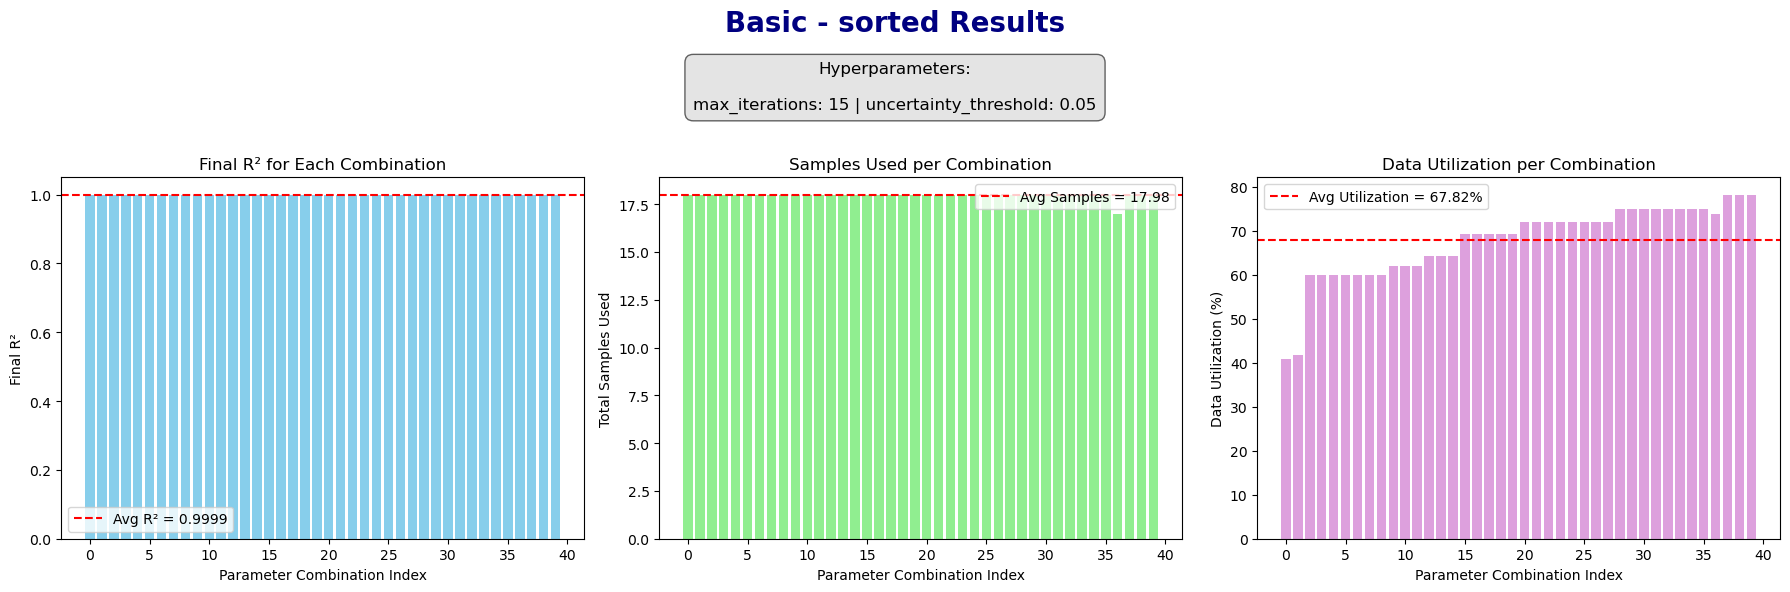

Average Final R²: 0.9999
Average Samples Used: 17.98
Average Data Utilization: 67.82%


In [ ]:
results_basic = run_active_sampling_basic(params_mostData, data_filtered, sort=True, verbose=False, **basic_hyperparams)
visualize_aggregated_results(results_basic, "Basic - sorted", basic_hyperparams)

Running stagnant active sampling: 100%|██████████| 40/40 [00:23<00:00,  1.71it/s]


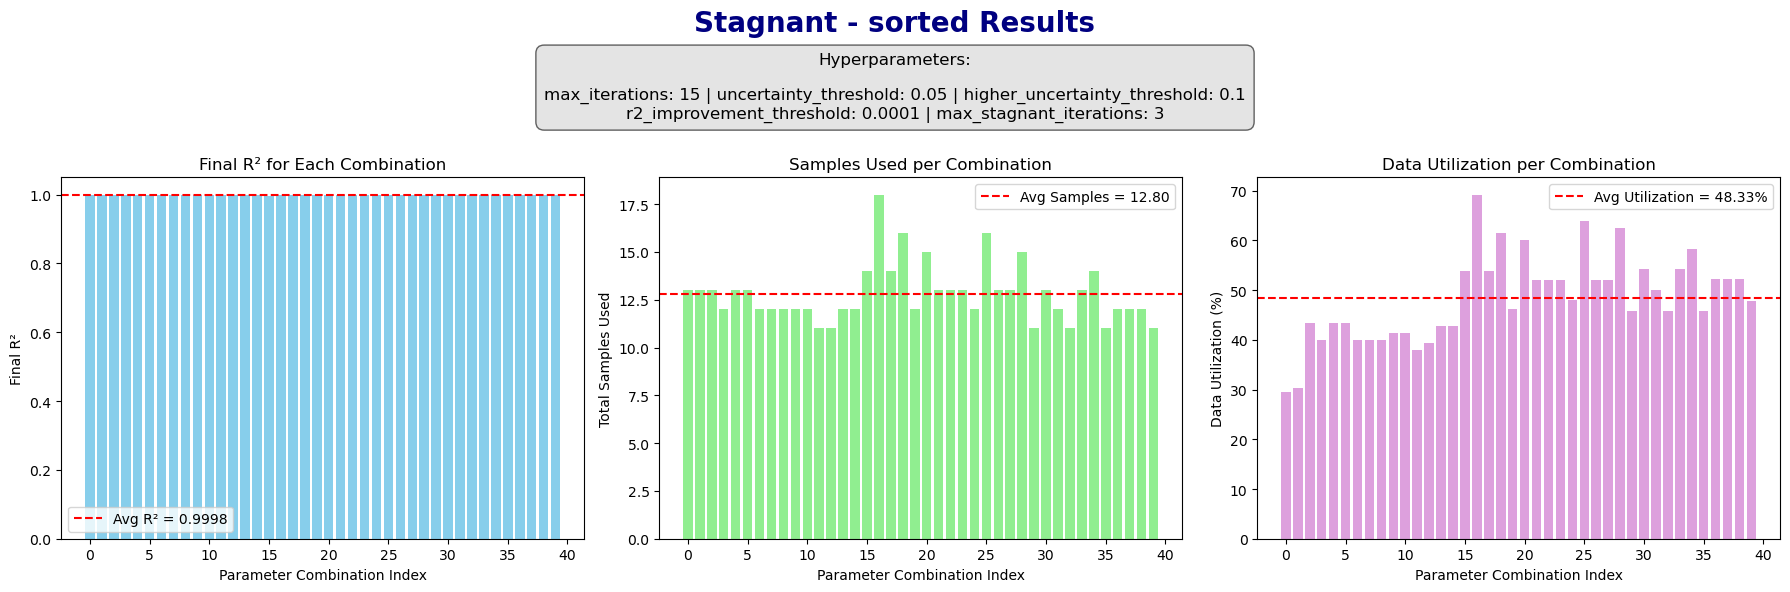

Average Final R²: 0.9998
Average Samples Used: 12.80
Average Data Utilization: 48.33%


In [ ]:
results_stagnant = run_active_sampling_stagnant(params_mostData, data_filtered, sort=True ,verbose=False, **stagnant_hyperparams)
visualize_aggregated_results(results_stagnant, "Stagnant - sorted", stagnant_hyperparams)

![Basic results](./images/step4-basic-sorted-Result(pre-tuning).png)
![stagnat results](./images/step4-stagnat-sorted-Result(pre-tuning).png)

**Wow!** This improvement is insane! but the data utilization is not so great, 67% percent for basic and 48% for stagnant, we can do better!
Lets fine tune the hyper parameters to lose some performance for less trining.

### Fine-tuning hyperparameters  to get the best R^2 to Data utilization

Our goal is to strike the right balance between model performance (as measured by R²) and data efficiency (minimizing the percentage of available data used).
In our active sampling loops, the stopping criteria play a key role in this trade-off.

 **What We’re Tuning**

**For the Basic Active Sampling Loop:**
- **max_iterations:** The maximum number of iterations allowed.
- **uncertainty_threshold:** The threshold below which the model’s uncertainty is considered low enough to stop sampling.

**For the Stagnant Active Sampling Loop:**
- **max_iterations:** Same as above.
- **uncertainty_threshold:** Primary stopping threshold.
- **higher_uncertainty_threshold:** A secondary threshold used when combined with stagnation.
- **r2_improvement_threshold:** The minimum improvement in R² required between iterations.
- **max_stagnant_iterations:** The maximum number of consecutive iterations with minimal R² improvement before stopping.

**How would we do that?**

We would use **BayesianOptimization** to fine-tune our hyperparameters because it efficiently explores the hyperparameter space by balancing exploration and exploitation. This method requires fewer iterations compared to exhaustive grid search and quickly converges to the best set of parameters that maximize our model's R².

Our objective function returns the final R², and we define bounds for key hyperparameters (like uncertainty thresholds, R² improvement thresholds, and the maximum stagnant iterations). The optimized parameters help improve model performance and data utilization.

#### Fine-Tuning with Bayesian Optimization


**Fine-Tuning Hyperparameters with Bayesian Optimization**

We use Bayesian Optimization to search for the best hyperparameters for our stagnant active sampling loop. Our objective function, `objective_hyperparams_stagnant/basic`, randomly selects 5 parameter combinations from `params_mostData` (with sorted data) and runs the stagnant active sampling loop on each. It then computes the average final R² and average data utilization. A penalty is applied if the average R² falls below 0.96, ensuring that only hyperparameters yielding strong performance are favored.

The optimizer then finds the hyperparameter values that maximize our objective. We save the optimized hyperparameters in a variable (`stagnant/basic_optimized_hyperparameters`) and also pickle them to disk for future use. Finally, we run the stagnant active sampling loop with these optimized parameters and visualize the results.

This process ensures we balance high R² performance with low data utilization.


In [ ]:
%%capture
%pip install bayesian-optimization

##### Basic hyperparameters optimization

In [ ]:
import random
from bayes_opt import BayesianOptimization
import pickle

def objective_hyperparams_basic(uncertainty_threshold, max_iterations):
    max_iterations = int(max_iterations)
    hyperparams = {"max_iterations": max_iterations, "uncertainty_threshold": uncertainty_threshold}

    selected_params = random.sample(params_mostData, 3)
    results_list = run_active_sampling_basic(selected_params, data_filtered, sort=True, verbose=False, **hyperparams)
    
    avg_r2 = sum(result['final_r2'] for result in results_list) / len(results_list)
    utilization_vals = [result['total_samples_used'] / result['total_data_count'] for result in results_list]
    avg_utilization = sum(utilization_vals) / len(utilization_vals)
    score = 1 - avg_utilization
    if avg_r2 < 0.96:
        penalty = (0.96 - avg_r2) * 100
        score -= penalty
    return score

pbounds_basic = {"uncertainty_threshold": (0.01, 0.1), "max_iterations": (10, 30)}

optimizer_basic = BayesianOptimization(f=objective_hyperparams_basic, pbounds=pbounds_basic, random_state=42)
optimizer_basic.maximize(init_points=5, n_iter=150)

basic_optimized_hyperparameters = {k: int(v) if k == "max_iterations" else v for k, v in optimizer_basic.max['params'].items()}

with open("basic_optimized_hyperparameters.pkl", "wb") as f:
    pickle.dump(basic_optimized_hyperparameters, f)


|   iter    |  target   | max_it... | uncert... |
-------------------------------------------------


Running basic active sampling: 100%|██████████| 3/3 [00:03<00:00,  1.05s/it]


| 1         | 0.5144    | 17.49     | 0.09556   |


Running basic active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]


| 2         | 0.3338    | 24.64     | 0.06388   |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.62it/s]


| 3         | 0.3593    | 13.12     | 0.02404   |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  2.06it/s]


| 4         | 0.5011    | 11.16     | 0.08796   |


Running basic active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]


| 5         | 0.476     | 22.02     | 0.07373   |


Running basic active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.07it/s]


| 6         | 0.2101    | 17.45     | 0.03864   |


Running basic active sampling: 100%|██████████| 3/3 [00:04<00:00,  1.55s/it]


| 7         | 0.0732    | 26.57     | 0.03702   |


Running basic active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.11it/s]


| 8         | 0.4464    | 12.03     | 0.05695   |


Running basic active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.45it/s]


| 9         | 0.5667    | 10.11     | 0.05174   |


Running basic active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.13it/s]


| 10        | 0.4188    | 23.35     | 0.0678    |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.63it/s]


| 11        | 0.4577    | 10.65     | 0.02937   |


Running basic active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.47it/s]


| 12        | 0.4906    | 18.84     | 0.08419   |


Running basic active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]


| 13        | 0.5328    | 10.37     | 0.04945   |


Running basic active sampling: 100%|██████████| 3/3 [00:03<00:00,  1.23s/it]


| 14        | 0.253     | 17.9      | 0.05386   |


Running basic active sampling: 100%|██████████| 3/3 [00:05<00:00,  1.89s/it]


| 15        | 0.08889   | 23.8      | 0.02102   |


Running basic active sampling: 100%|██████████| 3/3 [00:03<00:00,  1.17s/it]


| 16        | 0.0       | 22.08     | 0.02365   |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.98it/s]


| 17        | 0.4733    | 25.86     | 0.08955   |


Running basic active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.01it/s]


| 18        | 0.1707    | 18.39     | 0.02489   |


Running basic active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.39it/s]


| 19        | 0.3659    | 12.3      | 0.02786   |


Running basic active sampling: 100%|██████████| 3/3 [00:04<00:00,  1.35s/it]


| 20        | 0.04786   | 29.11     | 0.03353   |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.65it/s]


| 21        | 0.4889    | 26.27     | 0.0822    |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.59it/s]


| 22        | 0.4221    | 14.17     | 0.07975   |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.72it/s]


| 23        | 0.4332    | 26.38     | 0.07127   |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.54it/s]


| 24        | 0.3815    | 20.04     | 0.07047   |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.54it/s]


| 25        | 0.4569    | 22.69     | 0.07888   |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.82it/s]


| 26        | 0.3988    | 18.19     | 0.08213   |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.89it/s]


| 27        | 0.5022    | 11.36     | 0.04701   |


Running basic active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.39it/s]


| 28        | 0.6036    | 10.53     | 0.09099   |


Running basic active sampling: 100%|██████████| 3/3 [00:05<00:00,  1.72s/it]


| 29        | 0.05556   | 22.96     | 0.02055   |


Running basic active sampling: 100%|██████████| 3/3 [00:03<00:00,  1.04s/it]


| 30        | 0.1392    | 19.27     | 0.04267   |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.87it/s]


| 31        | 0.4843    | 19.3      | 0.07982   |


Running basic active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.14it/s]


| 32        | 0.2175    | 17.26     | 0.01591   |


Running basic active sampling: 100%|██████████| 3/3 [00:03<00:00,  1.29s/it]


| 33        | 0.0       | 26.36     | 0.02943   |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.60it/s]


| 34        | 0.4415    | 28.4      | 0.08193   |


Running basic active sampling: 100%|██████████| 3/3 [00:03<00:00,  1.25s/it]


| 35        | 0.02222   | 25.8      | 0.01671   |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.85it/s]


| 36        | 0.4456    | 14.31     | 0.08573   |


Running basic active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]


| 37        | 0.2745    | 17.09     | 0.05796   |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  2.20it/s]


| 38        | 0.5975    | 29.85     | 0.09738   |


Running basic active sampling: 100%|██████████| 3/3 [00:03<00:00,  1.05s/it]


| 39        | 0.2692    | 27.75     | 0.05319   |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.60it/s]


| 40        | 0.382     | 12.99     | 0.05059   |


Running basic active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


| 41        | 0.2575    | 17.69     | 0.05549   |


Running basic active sampling: 100%|██████████| 3/3 [00:03<00:00,  1.18s/it]


| 42        | 0.0       | 27.71     | 0.0235    |


Running basic active sampling: 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]


| 43        | 0.08222   | 22.47     | 0.03765   |


Running basic active sampling: 100%|██████████| 3/3 [00:03<00:00,  1.12s/it]


| 44        | 0.2759    | 29.98     | 0.05371   |


Running basic active sampling: 100%|██████████| 3/3 [00:03<00:00,  1.24s/it]


| 45        | 0.01333   | 27.19     | 0.0318    |


Running basic active sampling: 100%|██████████| 3/3 [00:03<00:00,  1.02s/it]


| 46        | 0.3072    | 24.64     | 0.06378   |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.52it/s]


| 47        | 0.3659    | 12.03     | 0.05725   |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.61it/s]


| 48        | 0.5383    | 10.53     | 0.09165   |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.97it/s]


| 49        | 0.5639    | 10.11     | 0.0521    |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.75it/s]


| 50        | 0.4725    | 18.84     | 0.08258   |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.92it/s]


| 51        | 0.46      | 11.36     | 0.05      |


Running basic active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.38it/s]


| 52        | 0.3237    | 26.69     | 0.06233   |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  2.36it/s]


| 53        | 0.624     | 12.71     | 0.09002   |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.91it/s]


| 54        | 0.4866    | 10.11     | 0.0502    |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.73it/s]


| 55        | 0.5605    | 25.86     | 0.08695   |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  2.04it/s]


| 56        | 0.5874    | 29.85     | 0.09818   |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.94it/s]


| 57        | 0.5833    | 12.72     | 0.08987   |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.51it/s]


| 58        | 0.4167    | 12.15     | 0.03426   |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.88it/s]


| 59        | 0.5417    | 17.49     | 0.09279   |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.85it/s]


| 60        | 0.4867    | 29.85     | 0.09247   |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.95it/s]


| 61        | 0.5293    | 12.71     | 0.09184   |


Running basic active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.45it/s]


| 62        | 0.5133    | 12.71     | 0.08792   |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  2.11it/s]


| 63        | 0.5618    | 17.48     | 0.09273   |


Running basic active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.45it/s]


| 64        | 0.4416    | 24.64     | 0.06676   |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  2.27it/s]


| 65        | 0.5912    | 10.53     | 0.08642   |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  2.19it/s]


| 66        | 0.5444    | 10.37     | 0.05247   |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.55it/s]


| 67        | 0.3681    | 13.64     | 0.02882   |


Running basic active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.35it/s]


| 68        | 0.5742    | 10.53     | 0.08382   |


Running basic active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]


| 69        | 0.5089    | 10.37     | 0.04563   |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.65it/s]


| 70        | 0.5339    | 29.85     | 0.0975    |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  2.44it/s]


| 71        | 0.6184    | 10.53     | 0.08657   |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.60it/s]


| 72        | 0.4733    | 25.85     | 0.08628   |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  2.26it/s]


| 73        | 0.5418    | 10.53     | 0.09378   |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]


| 74        | 0.5153    | 10.38     | 0.04731   |


Running basic active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.36it/s]


| 75        | 0.3127    | 18.06     | 0.05748   |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  2.16it/s]


| 76        | 0.5809    | 10.54     | 0.09206   |


Running basic active sampling: 100%|██████████| 3/3 [00:03<00:00,  1.04s/it]


| 77        | 0.1971    | 19.66     | 0.01677   |


Running basic active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.19it/s]


| 78        | 0.2253    | 28.74     | 0.05146   |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  2.21it/s]


| 79        | 0.6058    | 20.77     | 0.09541   |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.92it/s]


| 80        | 0.5789    | 25.86     | 0.08287   |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  2.14it/s]


| 81        | 0.5433    | 10.54     | 0.09371   |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  2.03it/s]


| 82        | 0.4794    | 10.54     | 0.08636   |


Running basic active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.09it/s]


| 83        | 0.2417    | 18.25     | 0.0241    |


Running basic active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.27it/s]


| 84        | 0.4412    | 16.44     | 0.06818   |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.80it/s]


| 85        | 0.5496    | 12.72     | 0.09251   |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  2.21it/s]


| 86        | 0.4861    | 10.54     | 0.0976    |


Running basic active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.36it/s]


| 87        | 0.46      | 25.86     | 0.08472   |


Running basic active sampling: 100%|██████████| 3/3 [00:03<00:00,  1.25s/it]


| 88        | 0.5067    | 20.78     | 0.09541   |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.53it/s]


| 89        | 0.5022    | 11.35     | 0.04382   |


Running basic active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.35it/s]


| 90        | 0.4972    | 29.84     | 0.09539   |


Running basic active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.50it/s]


| 91        | 0.4577    | 10.38     | 0.04295   |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.83it/s]


| 92        | 0.6058    | 20.78     | 0.09173   |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.87it/s]


| 93        | 0.5947    | 17.48     | 0.09765   |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  2.07it/s]


| 94        | 0.5836    | 17.49     | 0.09921   |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  2.03it/s]


| 95        | 0.4783    | 11.36     | 0.03944   |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.88it/s]


| 96        | 0.4399    | 25.85     | 0.07915   |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.87it/s]


| 97        | 0.4968    | 12.12     | 0.06278   |


Running basic active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.01it/s]


| 98        | 0.01111   | 26.95     | 0.01014   |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.76it/s]


| 99        | 0.4387    | 20.78     | 0.08749   |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  2.11it/s]


| 100       | 0.56      | 25.86     | 0.0825    |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  2.13it/s]


| 101       | 0.5846    | 17.48     | 0.0962    |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.86it/s]


| 102       | 0.5117    | 12.72     | 0.09011   |


Running basic active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]


| 103       | 0.4671    | 20.78     | 0.09167   |


Running basic active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]


| 104       | 0.5656    | 11.16     | 0.09064   |


Running basic active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]


| 105       | 0.6032    | 20.77     | 0.09764   |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  2.22it/s]


| 106       | 0.4499    | 10.11     | 0.05455   |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.99it/s]


| 107       | 0.4727    | 21.59     | 0.08573   |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  2.14it/s]


| 108       | 0.5758    | 11.16     | 0.09582   |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  2.03it/s]


| 109       | 0.5498    | 20.77     | 0.09206   |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  2.55it/s]


| 110       | 0.5533    | 20.77     | 0.09716   |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  2.37it/s]


| 111       | 0.5816    | 17.48     | 0.08953   |


Running basic active sampling: 100%|██████████| 3/3 [00:03<00:00,  1.06s/it]


| 112       | 0.08527   | 29.23     | 0.03222   |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  2.23it/s]


| 113       | 0.4788    | 17.48     | 0.08824   |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  2.50it/s]


| 114       | 0.5833    | 11.16     | 0.09418   |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  2.22it/s]


| 115       | 0.5476    | 10.54     | 0.0892    |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  2.18it/s]


| 116       | 0.476     | 25.86     | 0.07777   |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  2.38it/s]


| 117       | 0.5624    | 11.15     | 0.09145   |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  2.11it/s]


| 118       | 0.5482    | 11.17     | 0.09319   |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  2.39it/s]


| 119       | 0.4656    | 10.37     | 0.05713   |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.88it/s]


| 120       | 0.4178    | 17.48     | 0.08333   |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.77it/s]


| 121       | 0.4452    | 21.09     | 0.07447   |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  2.45it/s]


| 122       | 0.5408    | 11.15     | 0.09883   |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]


| 123       | 0.4794    | 12.72     | 0.09803   |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  2.66it/s]


| 124       | 0.5478    | 11.17     | 0.0981    |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.55it/s]


| 125       | 0.5437    | 17.49     | 0.08772   |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.63it/s]


| 126       | 0.626     | 20.77     | 0.09141   |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  2.45it/s]


| 127       | 0.5854    | 11.15     | 0.09098   |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  2.20it/s]


| 128       | 0.5183    | 11.14     | 0.09011   |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  2.13it/s]


| 129       | 0.5306    | 11.14     | 0.09401   |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  2.80it/s]


| 130       | 0.5694    | 11.13     | 0.09291   |


Running basic active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.11it/s]


| 131       | 0.01282   | 23.9      | 0.03177   |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  2.47it/s]


| 132       | 0.535     | 11.16     | 0.09333   |


Running basic active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.11it/s]


| 133       | 0.1111    | 22.66     | 0.02182   |


Running basic active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.15it/s]


| 134       | 0.1311    | 26.61     | 0.04757   |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  2.27it/s]


| 135       | 0.493     | 17.4      | 0.07972   |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.86it/s]


| 136       | 0.5026    | 11.15     | 0.08489   |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.90it/s]


| 137       | 0.3833    | 12.42     | 0.05921   |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.58it/s]


| 138       | 0.36      | 18.24     | 0.06038   |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  2.32it/s]


| 139       | 0.4667    | 11.15     | 0.08627   |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  2.18it/s]


| 140       | 0.5137    | 12.71     | 0.08598   |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.63it/s]


| 141       | 0.3287    | 14.22     | 0.05302   |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  2.27it/s]


| 142       | 0.5189    | 11.13     | 0.08854   |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  2.07it/s]


| 143       | 0.5018    | 11.17     | 0.08815   |


Running basic active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]


| 144       | 0.5966    | 11.13     | 0.09367   |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  2.01it/s]


| 145       | 0.5568    | 17.48     | 0.09313   |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  2.31it/s]


| 146       | 0.5656    | 11.14     | 0.09819   |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.92it/s]


| 147       | 0.4381    | 12.23     | 0.07602   |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  2.27it/s]


| 148       | 0.5472    | 11.13     | 0.09963   |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  2.21it/s]


| 149       | 0.6115    | 11.12     | 0.09648   |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.80it/s]


| 150       | 0.3665    | 17.7      | 0.07217   |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.78it/s]


| 151       | 0.4583    | 12.02     | 0.05286   |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  1.88it/s]


| 152       | 0.4287    | 17.49     | 0.08641   |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  2.47it/s]


| 153       | 0.5395    | 10.53     | 0.0786    |


Running basic active sampling: 100%|██████████| 3/3 [00:02<00:00,  1.45it/s]


| 154       | 0.2957    | 15.65     | 0.01972   |


Running basic active sampling: 100%|██████████| 3/3 [00:01<00:00,  2.37it/s]

| 155       | 0.5339    | 11.12     | 0.09261   |


Running basic active sampling: 100%|██████████| 40/40 [00:21<00:00,  1.86it/s]


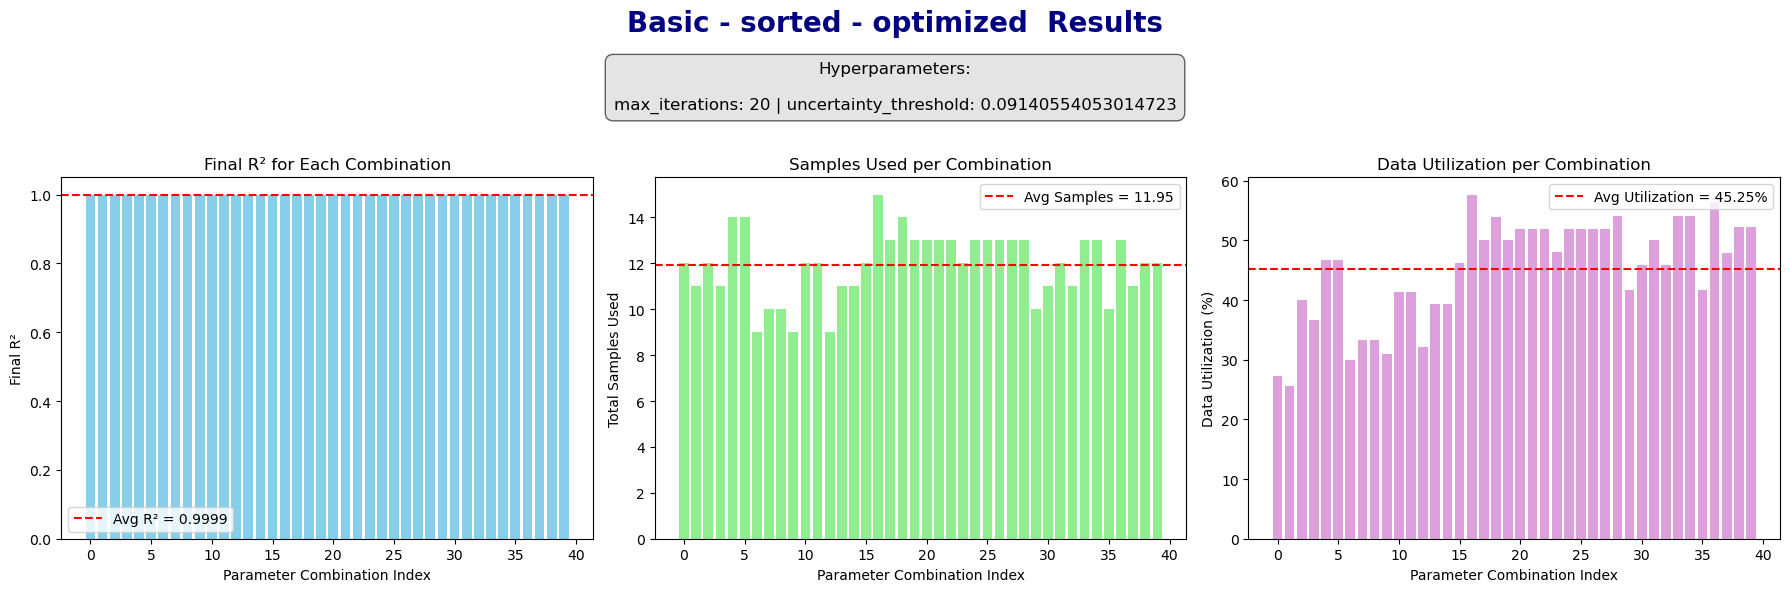

Average Final R²: 0.9999
Average Samples Used: 11.95
Average Data Utilization: 45.25%


In [ ]:
with open("basic_optimized_hyperparameters.pkl", "rb") as f:
    basic_optimized_hyperparameters = pickle.load(f)

results_basic = run_active_sampling_basic(params_mostData, data_filtered, sort=True, verbose=False, **basic_optimized_hyperparameters)
visualize_aggregated_results(results_basic, "Basic - sorted - optimized ", basic_optimized_hyperparameters)

##### Stagnant hyperparameters optimization

In [ ]:
import random
from bayes_opt import BayesianOptimization
import pickle

def objective_hyperparams_stagnant(uncertainty_threshold, higher_uncertainty_threshold, r2_improvement_threshold, max_stagnant_iterations, max_iterations):
    max_stagnant_iterations = int(max_stagnant_iterations)
    max_iterations = int(max_iterations)
    hyperparams = {
        "max_iterations": max_iterations,
        "uncertainty_threshold": uncertainty_threshold,
        "higher_uncertainty_threshold": higher_uncertainty_threshold,
        "r2_improvement_threshold": r2_improvement_threshold,
        "max_stagnant_iterations": max_stagnant_iterations,
    }
    selected_params = random.sample(params_mostData, 3)
    results_list = run_active_sampling_stagnant(selected_params, data_filtered, sort=True, verbose=False, **hyperparams)
    avg_r2 = sum(result['final_r2'] for result in results_list) / len(results_list)
    utilization_vals = [result['total_samples_used'] / result['total_data_count'] for result in results_list]
    avg_utilization = sum(utilization_vals) / len(utilization_vals)
    score = 1 - avg_utilization
    if avg_r2 < 0.96:
        penalty = (0.96 - avg_r2) * 100
        score -= penalty
    return score

pbounds = {
    "uncertainty_threshold": (0.01, 0.1),
    "higher_uncertainty_threshold": (0.05, 0.2),
    "r2_improvement_threshold": (1e-5, 1e-3),
    "max_stagnant_iterations": (2, 5),
    "max_iterations": (10, 30),
}

optimizer = BayesianOptimization(
    f=objective_hyperparams_stagnant,
    pbounds=pbounds,
    random_state=42,
)
optimizer.maximize(init_points=5, n_iter=150)

stagnant_optimized_hyperparameters = {
    k: int(v) if k in ['max_iterations', 'max_stagnant_iterations'] else v 
    for k, v in optimizer.max['params'].items()
}

with open("stagnant_optimized_hyperparameters.pkl", "wb") as f:
    pickle.dump(stagnant_optimized_hyperparameters, f)


In [ ]:
import pickle

with open("stagnant_optimized_hyperparameters.pkl", "rb") as f:
    stagnant_optimized_hyperparameters = pickle.load(f)

results_stagnant = run_active_sampling_stagnant(params_mostData, data_filtered, sort=True ,verbose=False, **stagnant_optimized_hyperparameters)
visualize_aggregated_results(results_stagnant, "Stagnant - sorted - optimized", stagnant_optimized_hyperparameters)


##### Hyperparameters Fine-Tuning Result Analysis

After fine-tuning our hyperparameters using Bayesian Optimization, we achieved impressive improvements in data utilization without sacrificing model performance.

**Results visualized**

**Before optimization:**
![Basic results pre](./images/step4-basic-sorted-Result(pre-tuning).png)
![stagnat results pre](./images/step4-stagnat-sorted-Result(pre-tuning).png)


**After optimization:**
![Basic results post](./images/step4-optimized-basic.png)
![stagnat results post](./images/step4-optimized-stagnat.png)


**Compression**

| **Model**    | **Metric**           | **Before Tuning**               | **After Tuning**                | **Percentage Change**        |
|--------------|----------------------|---------------------------------|---------------------------------|------------------------------|
| **Stagnant** | Data Utilization     | 48.24% (~12.78 samples/run)     | 37.52% (~9.95 samples/run)         | ~25% reduction               |
|              | R² Reduction         | 0% drop                         | ~0.13% drop (<0.0015 reduction)   | ~0.13% drop (negligible)     |
| **Basic**    | Data Utilization     | 67.82% (~18 samples/run)      | 42.94% (~11.35 samples/run)         | ~36% reduction               |
|              | R² Reduction         | 0% drop                         | No visible drop                | 0% change                   |


**Summary**

We are very pleased with the final results. With the tuned hyperparameters, our stagnant model now uses only about 10 samples per run to predict the entire month’s prices with nearly 100% accuracy. This level of efficiency and performance is truly remarkable and demonstrates the strength of our approach in balancing model accuracy with data efficiency.